# This script is meant to take .npz files and create data visualizations

In [15]:
# Import Standard Libraries
import numpy as np
import os
import datetime
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import scipy

processed_data_dir = os.path.join(os.getcwd(), "processed_data")

In [16]:
def get_drug_times(batch_id: str, drug_name: str, start_delay=datetime.timedelta(), length=None):

    # start_delay = datetime.timedelta of delay from "drug recording start time"
    # length = datetime.timedelta of length of recording from start time (accounting to the delay)
    drug_times = {
        "O9-12":{
            "Control":[datetime.datetime(2023, 5, 3, 17, 33), datetime.datetime(2023, 5, 18, 12, 10)],
            "4-AP":[datetime.datetime(2023, 5, 18, 12, 25), datetime.datetime(2023, 5, 18, 18, 15)],
            "No Drug":[datetime.datetime(2023, 5, 18, 18, 30), datetime.datetime(2023, 5, 19, 9, 15)],
            "Bicuculline":[datetime.datetime(2023, 5, 19, 9, 30), datetime.datetime(2023, 5, 19, 15, 25)],
            "Tetrodotoxin":[datetime.datetime(2023, 5, 19, 15, 40), datetime.datetime(2023, 5, 19, 21, 40)],
        },
        "O13-16":{
            "Control":[datetime.datetime(2023, 5, 25, 19, 18), datetime.datetime(2023, 6, 8, 18, 50)],
            "4-AP":[datetime.datetime(2023, 6, 8, 19, 5), datetime.datetime(2023, 6, 8, 23, 35)],
            "No Drug":[datetime.datetime(2023, 6, 8, 23, 50), datetime.datetime(2023, 6, 9, 10, 5)],
            "Bicuculline":[datetime.datetime(2023, 6, 9, 10, 20), datetime.datetime(2023, 6, 9, 15, 25)],
            "Tetrodotoxin":[datetime.datetime(2023, 6, 9, 15, 40), datetime.datetime(2023, 6, 9, 21, 40)],
        },
        "O17-20":{
            "Control":[datetime.datetime(2023, 6, 22, 15, 40), datetime.datetime(2023, 7, 12, 12, 55)],
            "4-AP":[datetime.datetime(2023, 7, 12, 13, 10), datetime.datetime(2023, 7, 12, 18, 10)],
            "No Drug":[datetime.datetime(2023, 7, 12, 18, 25), datetime.datetime(2023, 7, 13, 12, 20)],
            "Bicuculline":[datetime.datetime(2023, 7, 13, 12, 35), datetime.datetime(2023, 7, 13, 18, 0)],
            "Tetrodotoxin":[datetime.datetime(2023, 7, 13, 18, 15), datetime.datetime(2023, 7, 14, 0, 15)],
        },
        "O21-24":{
            "Control":[datetime.datetime(2024, 7, 1, 13, 53), datetime.datetime(2024, 7, 9, 13, 25)],
            "4-AP":[datetime.datetime(2024, 7, 9, 13, 45), datetime.datetime(2024, 7, 9, 17, 45)],
            "No Drug":[datetime.datetime(2024, 7, 9, 18, 0), datetime.datetime(2024, 7, 10, 10, 35)],
            "Bicuculline":[datetime.datetime(2024, 7, 10, 10, 50), datetime.datetime(2024, 7, 10, 15, 50)],
            "Tetrodotoxin":[datetime.datetime(2024, 7, 10, 16, 5), datetime.datetime(2024, 7, 10, 22, 5)],
        },
        "O25-28":{
            "Control":[datetime.datetime(2024, 10, 1, 16, 26), datetime.datetime(2024, 10, 14, 12, 50)],
            "4-AP":[datetime.datetime(2024, 10, 14, 13, 5), datetime.datetime(2024, 10, 14, 18, 0)],
            "No Drug":[datetime.datetime(2024, 10, 14, 18, 25), datetime.datetime(2024, 10, 15, 13, 15)],
            "Bicuculline":[datetime.datetime(2024, 10, 15, 13, 30), datetime.datetime(2024, 10, 15, 18, 25)],
            "Tetrodotoxin":[datetime.datetime(2024, 10, 15, 18, 35), datetime.datetime(2024, 10, 16, 0, 35)],
        },
    }

    start_time, end_time = drug_times[batch_id][drug_name]

    # Apply Delay
    start_time += start_delay

    # Segment Recording based on length (if given)
    if length is not None:
        end_time = start_time + length

    return start_time, end_time

def make_session_dict(batch_ids, drug_names, start_delay=datetime.timedelta(), length=None):

    session = {}

    for batch in batch_ids:
        session[batch] = {}

        for drug in drug_names:
            session[batch][drug] = get_drug_times(batch, drug, start_delay, length)
    
    return session

def get_batch_folder(session_times, processed_data_dir):
    # Get folder (stored in processed_date_dir) which contains session times

    start_time, end_time = session_times
    batch_folders = os.listdir(processed_data_dir)

    for batch_folder in batch_folders:
        
        # skip iteration is batch_folder isn't a directory
        if not os.path.isdir(os.path.join(processed_data_dir, batch_folder)):
            continue

        batch_files = os.listdir(os.path.join(processed_data_dir, batch_folder))

        file_format = '%y%m%d.npz'
        batch_dates = [datetime.datetime.strptime(file, file_format).date() for file in batch_files]

        if start_time.date() in batch_dates and end_time.date() in batch_dates:
            return batch_folder
    
    raise Exception("One or both of session time dates not found in processed_data_dir")

def get_time_array(type_str = False):

    # Create an empty array to store time objects
    time_array = np.empty(24 * 60, dtype=object)
    
    # Fill the array with time objects for each minute of the day
    for hour in range(24):
        for minute in range(60):
            index = hour * 60 + minute
            time_object = datetime.time(hour=hour, minute=minute)

            if type_str:
                time_array[index] = time_object.strftime("%H%M")
            else:
                time_array[index] = time_object
    
    return time_array

def get_organoid_ids(batch):

    organoid_ids = {
        "O9-12": ["O9", "O10", "O11", "O12"],
        "O13-16": ["O13", "O14", "O15", "O16"],
        "O17-20": ["O17", "O18", "O19", "O20"],
        "O21-24": ["O21", "O22", "O23", "O24"],
        "O25-28": ["O25", "O26", "O27", "O28"]
    }

    return organoid_ids[batch]

def get_num_elec_inside(batch_id: str):

    elec_inside = {
                "O9-12": [32, 16, 20, 14],
                "O13-16": [25, 13, 11, 11],
                "O17-20": [22, 19, 20, 17],
                "O21-24": [18, 21, 22, 23],
                "O25-28": [20, 32, 26, 24],
                }
    return elec_inside[batch_id]

In [29]:
# Create a Function to Fetch all data between session times in a session dictionary
def fetch_data(session_times: tuple, processed_data_dir):

    # IMPEDANCE FILTER (ohms)
    I1 = 50000
    I2 = 2000000

    # RMS FILTER (uV)
    rms1 = 4 
    rms2 = 100

    # find all recorded data between session times
    start_time, end_time = session_times

    # get batch folder (in processed_data_dir)
    batch_folder = get_batch_folder(session_times=session_times, processed_data_dir=processed_data_dir)

    # get time array (all minutes across a day)
    time_array = get_time_array()

    # get files for wanted batch recording (sort by date)
    batch_files = np.sort(np.array(os.listdir(os.path.join(processed_data_dir, batch_folder))))

    # get dates for batch files
    file_format = '%y%m%d.npz'
    batch_dates = np.array([datetime.datetime.strptime(file, file_format).date() for file in batch_files])

    # get files for dates within session_times 
    files = batch_files[(start_time.date() <= batch_dates) & (batch_dates <= end_time.date())]
    
    for file in files:
        print(f"Processing {file}")
  
        # extract data from file
        file_dict = dict(np.load(os.path.join(processed_data_dir, batch_folder, file)))

        # I don't like having time = axis0, I'm changing the order to 4 x 32 x 1440 x 10
        file_dict["data"] = np.transpose(file_dict["data"], (1, 2, 0, 3))
        file_dict["rms_mask"] = np.transpose(file_dict["rms_mask"], (1, 2, 0))

        file_data = file_dict["data"]

        # create (4 x 32 x 1440 x 4) logical array of all masks [minute, rms, inside, impedance]

        file_mask = np.stack(
            (
                np.tile(file_dict["minute_mask"][np.newaxis, np.newaxis, :], (4, 32, 1)), # 1440 -> 4 x 32 x 1440
                file_dict["rms_mask"], # 4 x 32 x 1440
                np.tile(file_dict["elec_inside_mask"][:, :, np.newaxis], (1, 1, 1440)), # 4 x 32 -> 4 x 32 x 1440
                np.tile(((I1 <= file_dict["impedance_values"]) & (file_dict["impedance_values"] <= I2))[:, :, np.newaxis], (1, 1, 1440)) # 4 x 32 -> 4 x 32 x 1440
            ),
            axis = -1
        )

        # time indexing (baseed on start and end time)
        t_idx = np.full(1440, True, dtype=bool)
        if file == files[0]:
            # remove data before start time
            t_idx = t_idx & (time_array>=start_time.time())
        
        if file == files[-1]:
            # remove data after end time
            t_idx = t_idx & (time_array<=end_time.time())

        file_data[:, :, ~t_idx, :] = np.nan
        file_mask[:, :, ~t_idx, :] = False     

        # concatenate file array with session array
        if file == files[0]:
            # initialize array
            data = file_data
            mask = file_mask

        else:
            # concatenate array (along time (1440) axis)
            data = np.concatenate((data, file_data), axis=2)
            mask = np.concatenate((mask, file_mask), axis=2)
        
        # Print summary values (mask)
        minute_mask = file_mask[0,0,:,0]
        print(f"{np.sum(minute_mask)}/{file_mask.shape[2]} minutes sucessfully recorded")
        print(f"{np.round((np.sum(file_mask[:,:,:,1])/np.size(file_mask[:,:,minute_mask,1]))*100, decimals=2)}% of data in valid rms range")
        print(f"{np.sum(file_mask[:,:,0,2])}/128 electrodes inside organoids")
        print(f"{np.sum(file_mask[:,:,0,3])}/128 electrodes in valid impedance range")
        print(f"{np.round((np.sum(np.all(file_mask, axis=3))/np.size(file_mask[:,:,:,0]))*100, decimals=2)}% of data pass all filters")
        print("")
  

    return data, mask

def fetch_other_values(session_times: dict, processed_data_dir, return_value):
    
    # find all recorded data between session times
    start_time, end_time = session_times

    # get batch folder (in processed_data_dir)
    batch_folder = get_batch_folder(session_times=session_times, processed_data_dir=processed_data_dir)

    # get files for wanted batch recording (sort by date)
    batch_files = np.sort(np.array(os.listdir(os.path.join(processed_data_dir, batch_folder))))

    # get dates for batch files
    file_format = '%y%m%d.npz'
    batch_dates = np.array([datetime.datetime.strptime(file, file_format).date() for file in batch_files])

    # get files for dates within session_times 
    files = batch_files[(start_time.date() <= batch_dates) & (batch_dates <= end_time.date())]

    for file in files:
        print(f"Processing {file}")

        file_dict = dict(np.load(os.path.join(processed_data_dir, batch_folder, file)))
        
        if return_value == "impedance":
            data_values = file_dict["impedance_values"][:,:, np.newaxis]

        elif return_value == "rms":
            data_values = np.transpose(file_dict["rms_mask"], (1, 2, 0))
        
        if file == files[0]:
            data = data_values
        else:
            data = np.concatenate((data, data_values), axis=2)

    
    return data


In [28]:
def get_data_dict(session_dict: dict, processed_data_dir, return_value=None):

    # return a dictionary organized the same way as the session_dict replacing the session times with the data between them

    data_dict = {}

    for key, value in session_dict.items():
        
        print(f"{key}:")
        
        # account for different number of layers throughout dict
        if isinstance(value, dict):
            data_dict[key] = get_data_dict(value, processed_data_dir, return_value=return_value)

        # once reached the "value" layer (get data)
        if isinstance(value, tuple):
            
            if return_value is None:
                data_dict[key] = fetch_data(session_times=value, processed_data_dir=processed_data_dir)
            else:
                data_dict[key] = fetch_other_values(session_times=value, processed_data_dir=processed_data_dir, return_value=return_value)
    
    return data_dict
            

In [19]:
def get_total_mask(mask_array, minute=True, rms=True, elec_inside=True, impedance=True):
    
    filter_idx = [minute, rms, elec_inside, impedance]
    return np.all(mask_array[:,:,:,filter_idx], axis=3)

def apply_mask(data, mask):

    if not data.shape == mask.shape:
        raise IndexError("Size of data needs to match the size of mask")
    
    array = np.full(data.shape, np.nan)
    array[mask] = data[mask]

    return array
    


In [20]:
# Filter Line Plots (time vs valid channels)

# input = 2 layer dict [batch, days]
# output = 4x1 figure (each organoid) with drug conditions labeled on x-axis

# make session dict
batch_ids = ["O9-12", "O13-16", "O17-20", "O21-24", "O25-28"]

session = {}
for batch_id in batch_ids:
    session[batch_id] = {}

    recording_start = get_drug_times(batch_id, "Control")[0]
    recording_end = get_drug_times(batch_id, "Tetrodotoxin")[1]

    # Iterate through the range of dates
    date_list = []
    date = recording_start.date()
    while date <= recording_end.date():
        # Append the date part of the datetime object to the list
        date_list.append(date)
        # Increment the current datetime by one day
        date += datetime.timedelta(days=1)
    
    for date in date_list:

        if date == date_list[0]:
            session[batch_id][date] = (recording_start, recording_start+datetime.timedelta(hours=1))

        elif date == date_list[-1]:
            session[batch_id][date] = (recording_end-datetime.timedelta(hours=1), recording_end)

        else:
            session[batch_id][date] = (datetime.datetime.combine(date, datetime.time(hour=2, minute=0)), datetime.datetime.combine(date, datetime.time(hour=3, minute=0)))
    



In [30]:
processed_data_dir = os.path.join(os.getcwd(), "processed_data")
data = get_data_dict(session, processed_data_dir)

O9-12:
2023-05-03:
Processing 230503.npz
61/1440 minutes sucessfully recorded
89.61% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
1.84% of data pass all filters

2023-05-04:
Processing 230504.npz
61/1440 minutes sucessfully recorded
79.03% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
1.69% of data pass all filters

2023-05-05:
Processing 230505.npz
61/1440 minutes sucessfully recorded
90.78% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
1.72% of data pass all filters

2023-05-06:
Processing 230506.npz
61/1440 minutes sucessfully recorded
75.77% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
1.55% of data pass all filters

2023-05-07:
Processing 230507.npz
61/1440 minutes sucessfully recorded
75.78% of data in valid rms range
0/128 electrodes inside organoids
0/

C:\Users\Organoid PC\AppData\Local\Temp\ipykernel_12140\284327272.py:82: RuntimeWarning: invalid value encountered in scalar divide
  print(f"{np.round((np.sum(file_mask[:,:,:,1])/np.size(file_mask[:,:,minute_mask,1]))*100, decimals=2)}% of data in valid rms range")


61/1440 minutes sucessfully recorded
68.17% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
1.16% of data pass all filters

2023-05-19:
Processing 230519.npz
61/1440 minutes sucessfully recorded
67.21% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
1.13% of data pass all filters

O13-16:
2023-05-25:
Processing 230525.npz
61/1440 minutes sucessfully recorded
51.01% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
0.76% of data pass all filters

2023-05-26:
Processing 230526.npz
61/1440 minutes sucessfully recorded
11.33% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
0.2% of data pass all filters

2023-05-27:
Processing 230527.npz
61/1440 minutes sucessfully recorded
9.38% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance r

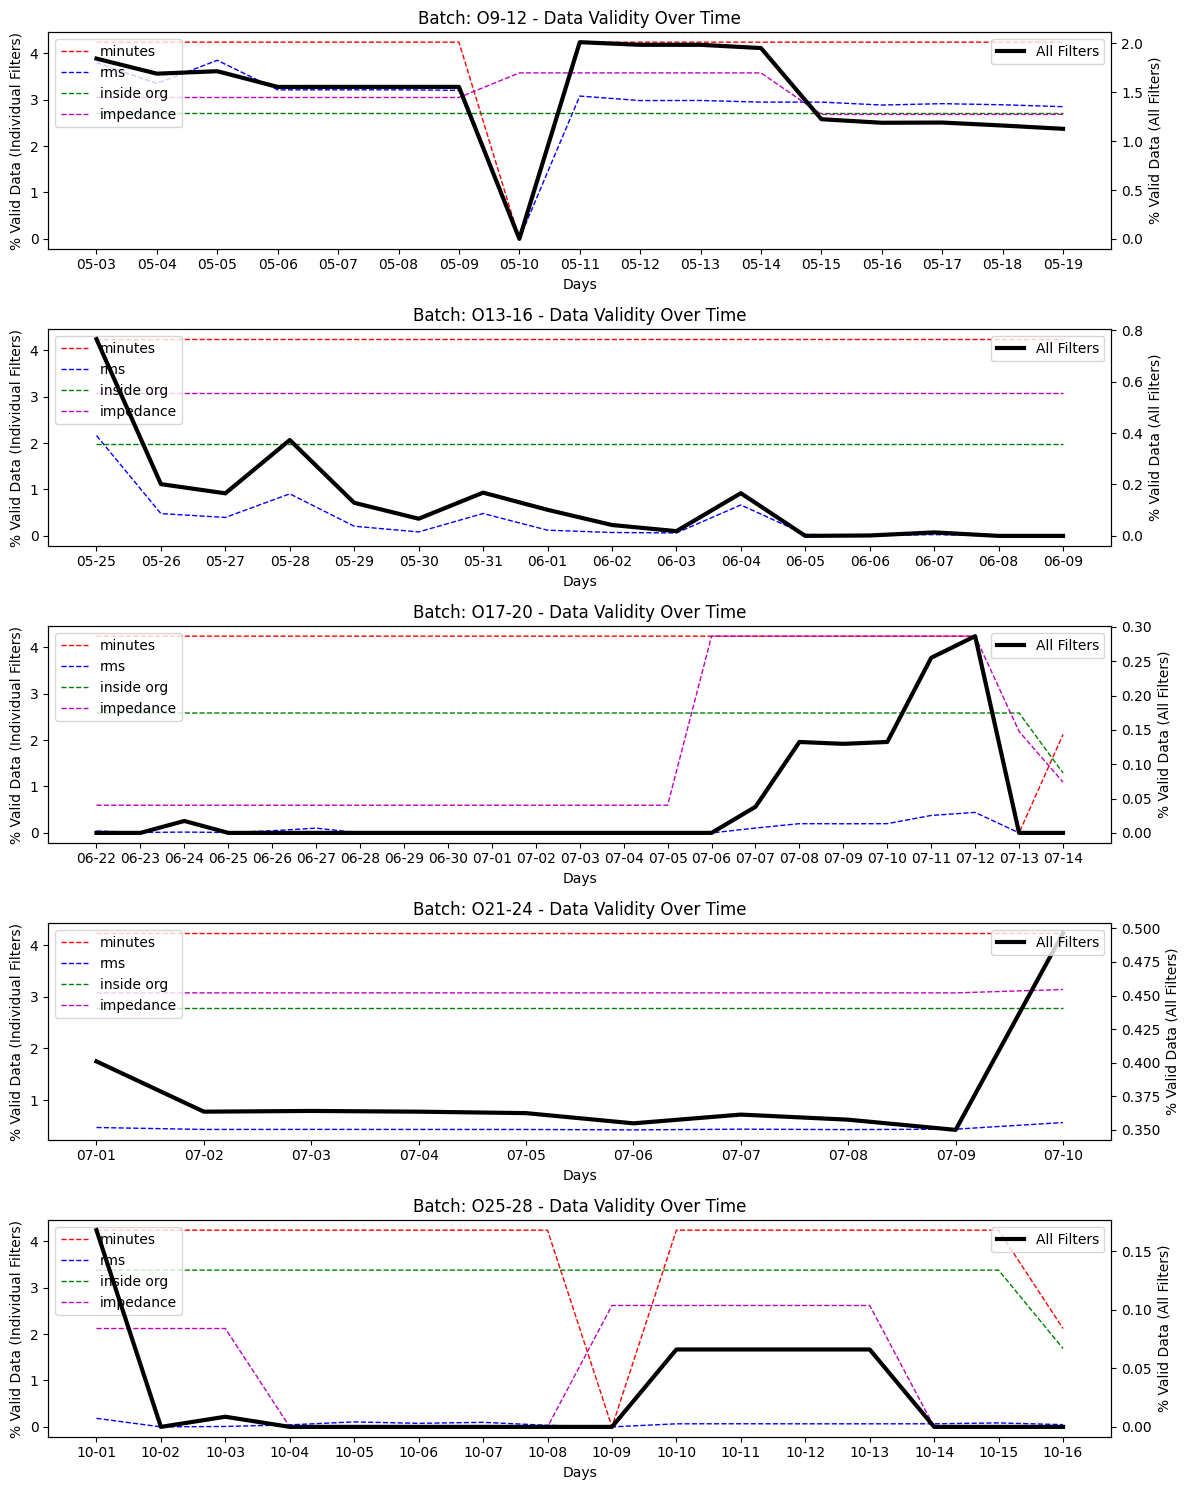

In [31]:
# Filter Line Plots (time vs valid channels)
# input = 2 layer dict [batch, days]
# output = Bx1 figure (days vs % data which passes)
F = 5
B = len(data)
filter_names = ["minutes", "rms", "inside org", "impedance"]
colors = ['r', 'b', 'g', 'm']
# Create a figure with Bx1 subplots
fig, axs = plt.subplots(B, 1, figsize=(12, 3*B))

for i, (batch, batch_dict) in enumerate(data.items()):

    # Need 
    # day vector
    # minute mask / rms mask / inside mask / impedance mask / all mask
    days = []
    D = len(batch_dict)
    batch_data = np.zeros((F, D))
    for d, (day, (_, mask)) in enumerate(batch_dict.items()): # d = day index

        total_data = np.size(mask[:,:,:,0])

        mask_list = []
        for f in range(F-1): # f = filter index

            mask_f = mask[:,:,:,f]
            batch_data[f, d] = (np.sum(mask_f) / total_data) * 100 # % of valid data for that filter

        batch_data[F-1, d] = (np.sum(np.all(mask, axis=3)) / total_data) * 100 # % of valid data for all filters
        days.append(day.strftime("%m-%d"))

    # Create a subplot for this batch
    ax1 = axs[i]
    
    # Plot all but the last line on ax1
    for f in range(F - 1):
        ax1.plot(days, batch_data[f], color=colors[f], label=filter_names[f], linewidth=1, linestyle='dashed')

    # Set labels and title for ax1
    ax1.set_xlabel('Days')
    ax1.set_ylabel('% Valid Data (Individual Filters)')
    ax1.set_title(f'Batch: {batch} - Data Validity Over Time')
    ax1.legend(loc='upper left')

    # Create a secondary axis for the last line
    ax2 = ax1.twinx()

    # Plot the last line on ax2
    ax2.plot(days, batch_data[F-1], color='k', label='All Filters', linewidth=3)

    # Set labels for ax2
    ax2.set_ylabel('% Valid Data (All Filters)')
    ax2.legend(loc='upper right')

# Layout so plots do not overlap
fig.tight_layout()

# Show the plot
plt.show()




# Investigate Drug Reactions

In [32]:
# Make Session Dict
batch_ids = ["O9-12", "O13-16", "O17-20", "O21-24", "O25-28"]
drug_names = ["Control", "4-AP", "No Drug", "Bicuculline", "Tetrodotoxin"]

session = make_session_dict(
    batch_ids=batch_ids, 
    drug_names=drug_names,
    start_delay=datetime.timedelta(minutes=10),
    length=datetime.timedelta(hours=5)
    )

In [33]:
# Make Session Dict
batch_ids = ["O9-12", "O13-16", "O17-20", "O21-24", "O25-28"]
drug_names = ["Control"]

session = make_session_dict(
    batch_ids=batch_ids, 
    drug_names=drug_names,
    start_delay=datetime.timedelta(hours=6),
    )

In [34]:
processed_data_dir = os.path.join(os.getcwd(), "processed_data")
data = get_data_dict(session, processed_data_dir)


O9-12:
Control:
Processing 230503.npz
27/1440 minutes sucessfully recorded
79.54% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
0.76% of data pass all filters

Processing 230504.npz
1440/1440 minutes sucessfully recorded
87.82% of data in valid rms range
82/128 electrodes inside organoids
92/128 electrodes in valid impedance range
40.85% of data pass all filters

Processing 230505.npz
1440/1440 minutes sucessfully recorded
80.26% of data in valid rms range
82/128 electrodes inside organoids
92/128 electrodes in valid impedance range
38.01% of data pass all filters

Processing 230506.npz
1440/1440 minutes sucessfully recorded
77.04% of data in valid rms range
82/128 electrodes inside organoids
92/128 electrodes in valid impedance range
37.0% of data pass all filters

Processing 230507.npz
1440/1440 minutes sucessfully recorded
75.77% of data in valid rms range
82/128 electrodes inside organoids
92/128 electrodes in valid impedance

C:\Users\Organoid PC\AppData\Local\Temp\ipykernel_12140\2341744670.py:29: RuntimeWarning: Mean of empty slice
  average_data = np.nanmean(drug_data, axis=1)


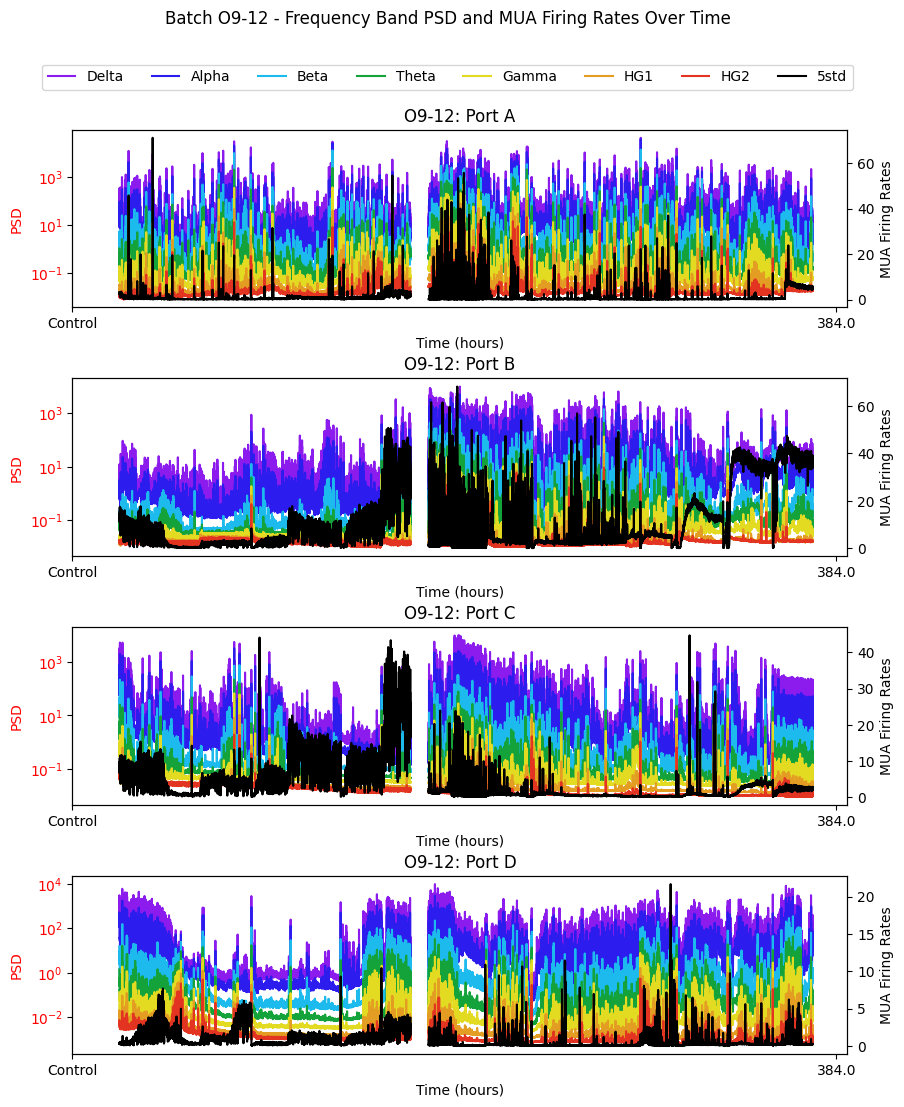

C:\Users\Organoid PC\AppData\Local\Temp\ipykernel_12140\2341744670.py:29: RuntimeWarning: Mean of empty slice
  average_data = np.nanmean(drug_data, axis=1)


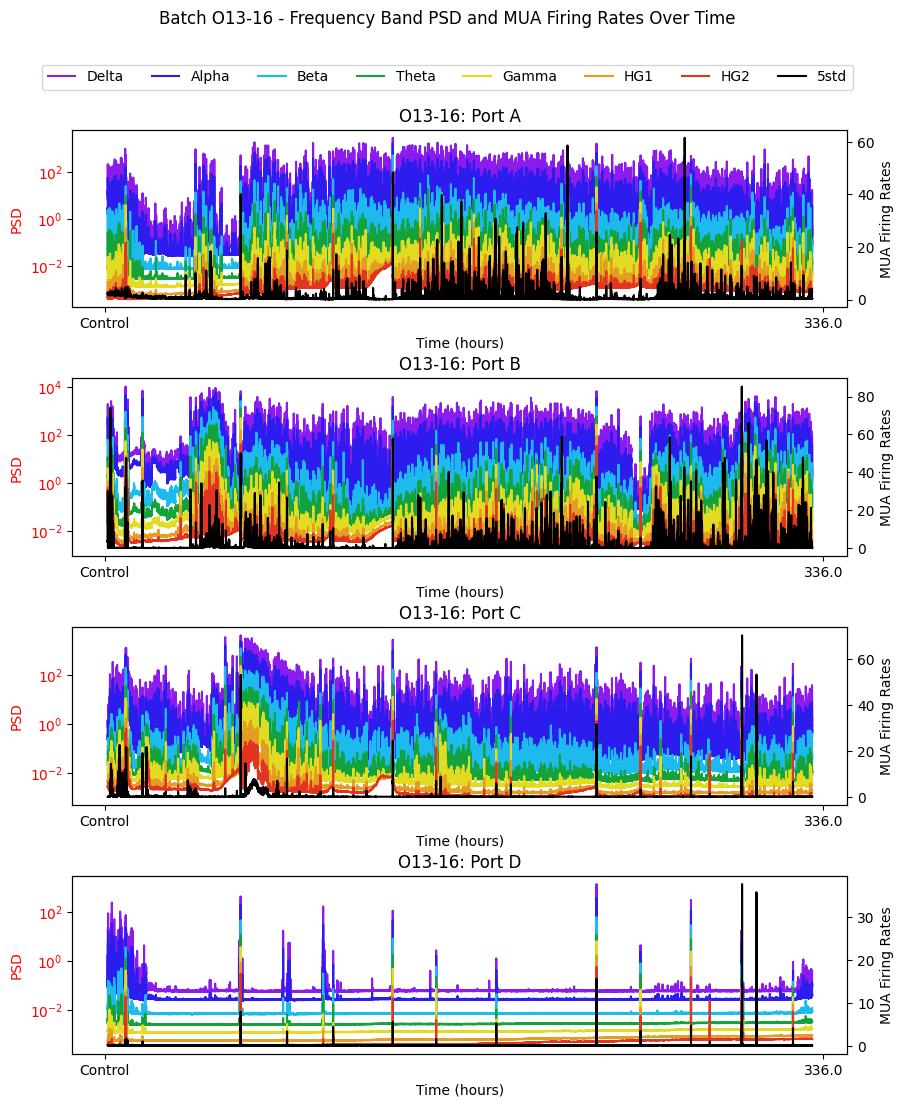

C:\Users\Organoid PC\AppData\Local\Temp\ipykernel_12140\2341744670.py:29: RuntimeWarning: Mean of empty slice
  average_data = np.nanmean(drug_data, axis=1)


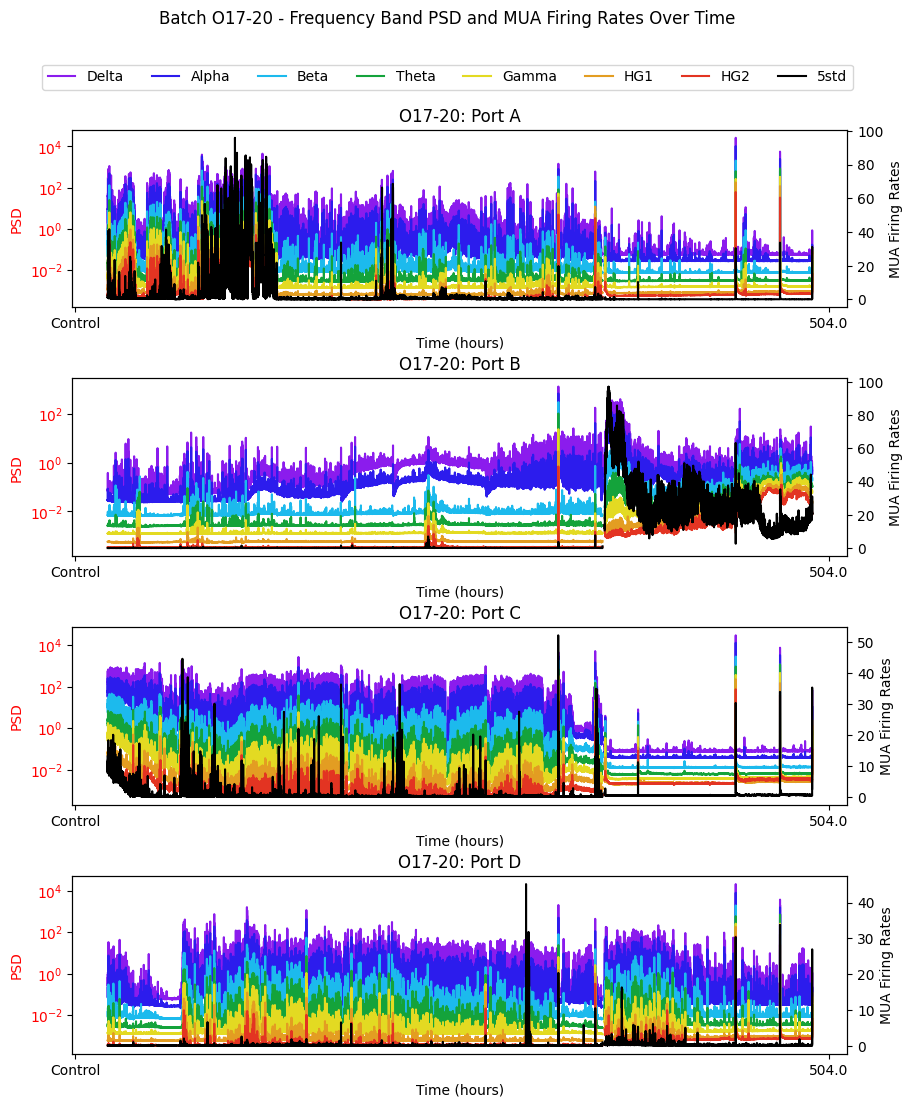

C:\Users\Organoid PC\AppData\Local\Temp\ipykernel_12140\2341744670.py:29: RuntimeWarning: Mean of empty slice
  average_data = np.nanmean(drug_data, axis=1)


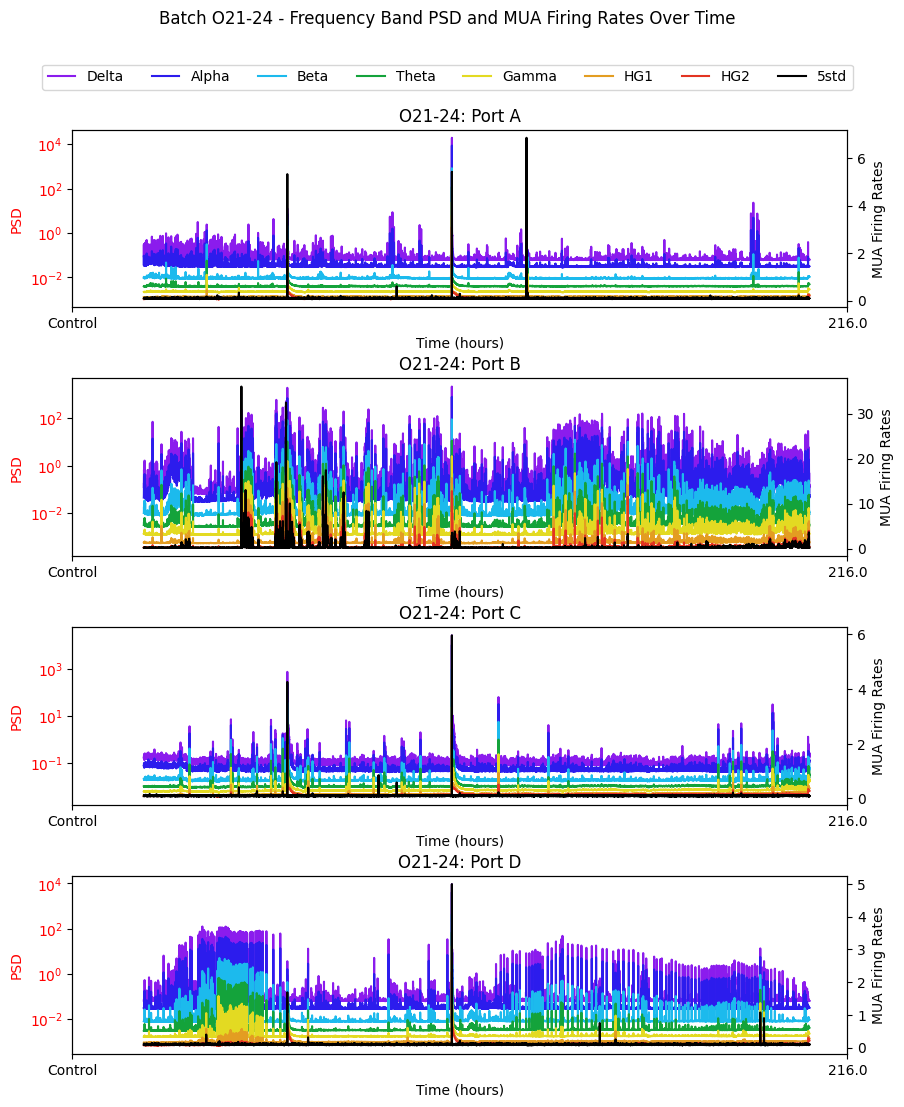

C:\Users\Organoid PC\AppData\Local\Temp\ipykernel_12140\2341744670.py:29: RuntimeWarning: Mean of empty slice
  average_data = np.nanmean(drug_data, axis=1)


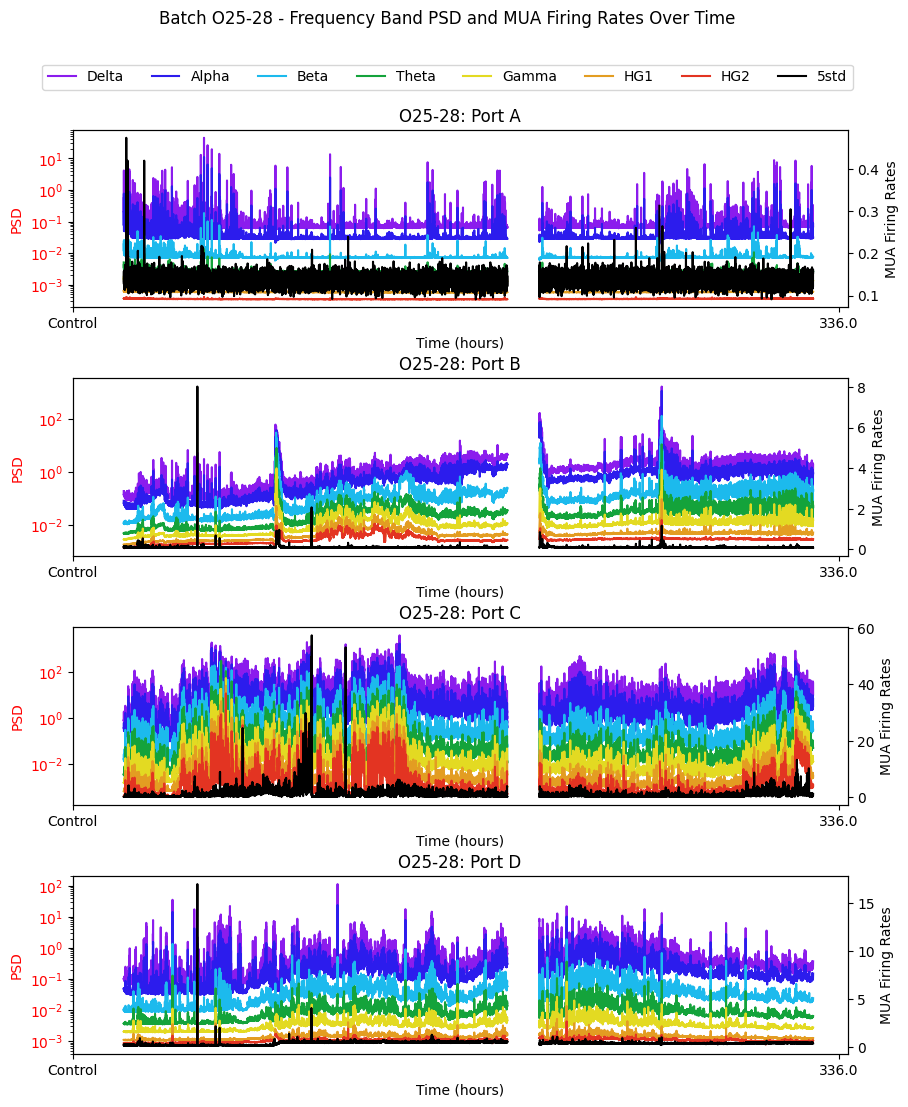

In [35]:
# Create a B Ox1 Figures 
# Each subplot will contain ax1(time vs PSD), ax2(time vs firing rate) for each organoid
# time will span across all drug time windows
# x-label will have 0 and total (# mins) and the drug labels

hg1_data = {}

B = len(data) # num batches
feature_mask = np.array([True, True, True, True, True, True, True, False, False, True]) # take out 35uV and 4i thresholds

feature_names = np.array(["Delta", "Alpha", "Beta", "Theta", "Gamma", "HG1", "HG2", "35uV", "4std", "5std"])[feature_mask]
organoid_names = np.array(["Port A", "Port B", "Port C", "Port D"])
colors = np.array(["#8b1ced", "#2c1ced", "#1cbaed", "#14a33b", "#e3da22", "#e39d22", "#e33422", "#a2a2a2", "#5f5f5f", "#000000"])[feature_mask]

for batch, batch_dict in data.items():

    batch_data = []
    drug_idx = []
    for drug, (drug_data, mask) in batch_dict.items():

        # get filter for valid channels
        data_mask = get_total_mask(mask, rms=False, impedance=False)
        drug_mask = np.tile(data_mask[:,:,:,np.newaxis], (1,1,1,10))

        # apply mask
        drug_data = apply_mask(drug_data, drug_mask)

        # average acrosss channels
        average_data = np.nanmean(drug_data, axis=1)
      
        # remove unwanted features
        average_data = average_data[:, :, feature_mask]

        # add drug index
        drug_idx.append(average_data.shape[1])

        # append to batch data list
        batch_data.append(average_data)
    drug_idx = np.cumsum(drug_idx)
    batch_data = np.concatenate(batch_data, axis=1) # organoid x time(min) x feature

    [O,T,F] = np.shape(batch_data)
    t = np.arange(T) # time (min)

    # Create a figure for each batch
    fig, axs = plt.subplots(O, 1, figsize=(10, 3*O))
    
    # Plot data for each organoid
    lines1 = []
    labels1 = []
    lines2 = []
    labels2 = []
    
    for o, ax in enumerate(axs):
        # Plot frequency band PSD (f=0:7) on the left axis
        for f in range(7):
            line = ax.plot(t, batch_data[o, :, f], color=colors[f], label=feature_names[f])[0]
            if o==1:
                lines1.append(line)
                labels1.append(feature_names[f])
        ax.set_yscale('log')
        ax.set_xlabel('Time (hours)')
        ax.set_ylabel('PSD', color='r')
        ax.tick_params(axis='y', labelcolor='r')
        
        # Plot MUA firing rates (f=7:10) on the right axis
        ax2 = ax.twinx()
        for f in range(7, len(feature_names)):
            line = ax2.plot(t, batch_data[o, :, f], color=colors[f], label=feature_names[f])[0]
            if o==1:
                lines2.append(line)
                labels2.append(feature_names[f])
        
        ax2.set_ylabel('MUA Firing Rates', color='k')
        ax2.tick_params(axis='y', labelcolor='k')
        
        # Set xticks
        drug_names = list(batch_dict.keys()) + [np.round(T/60, decimals=1)]
        xticks = [0]+ drug_idx[:-1].tolist() + [T]  # Exclude the last drug index
        ax.set_xticks(xticks)
        ax.set_xticklabels(drug_names)
        
        ax.set_title(f'{batch}: {organoid_names[o]}')
    
    # Combine legends across all subplots and place at the top
    fig.legend(lines1 + lines2, labels1 + labels2, loc='upper center', ncol=len(feature_names), bbox_to_anchor=(.5, .94))

    
    plt.subplots_adjust(hspace=.4)
    
    fig.suptitle(f'Batch {batch} - Frequency Band PSD and MUA Firing Rates Over Time')
    plt.show()

    hg1_data[batch] = np.nanmean(batch_data[:,:,6], axis=1)


# Correlation Coefficient

In [40]:
# Make Session Dict
batch_ids = ["O9-12", "O13-16", "O17-20", "O21-24", "O25-28"]
drug_names = ["Control"]

session = make_session_dict(
    batch_ids=batch_ids, 
    drug_names=drug_names,
    start_delay=datetime.timedelta(hours=8),
    length=datetime.timedelta(days=7)
    )

In [41]:
processed_data_dir = os.path.join(os.getcwd(), "processed_data")
data = get_data_dict(session, processed_data_dir)

O9-12:
Control:
Processing 230504.npz
1347/1440 minutes sucessfully recorded
88.42% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
38.27% of data pass all filters

Processing 230505.npz
1440/1440 minutes sucessfully recorded
80.26% of data in valid rms range
82/128 electrodes inside organoids
92/128 electrodes in valid impedance range
38.01% of data pass all filters

Processing 230506.npz
1440/1440 minutes sucessfully recorded
77.04% of data in valid rms range
82/128 electrodes inside organoids
92/128 electrodes in valid impedance range
37.0% of data pass all filters

Processing 230507.npz
1440/1440 minutes sucessfully recorded
75.77% of data in valid rms range
82/128 electrodes inside organoids
92/128 electrodes in valid impedance range
36.72% of data pass all filters

Processing 230508.npz
1440/1440 minutes sucessfully recorded
75.63% of data in valid rms range
82/128 electrodes inside organoids
92/128 electrodes in valid impeda

C:\Users\Organoid PC\AppData\Local\Temp\ipykernel_12140\284327272.py:82: RuntimeWarning: invalid value encountered in scalar divide
  print(f"{np.round((np.sum(file_mask[:,:,:,1])/np.size(file_mask[:,:,minute_mask,1]))*100, decimals=2)}% of data in valid rms range")


c:\Users\Organoid PC\anaconda3\envs\utah_organoids\lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Organoid PC\anaconda3\envs\utah_organoids\lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\Organoid PC\anaconda3\envs\utah_organoids\lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\Organoid PC\anaconda3\envs\utah_organoids\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\Organoid PC\anaconda3\envs\utah_organoids\lib\site-packages\numpy\core\_methods.py:195: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\Organoid PC\anaconda3\envs\utah_organoids\lib\

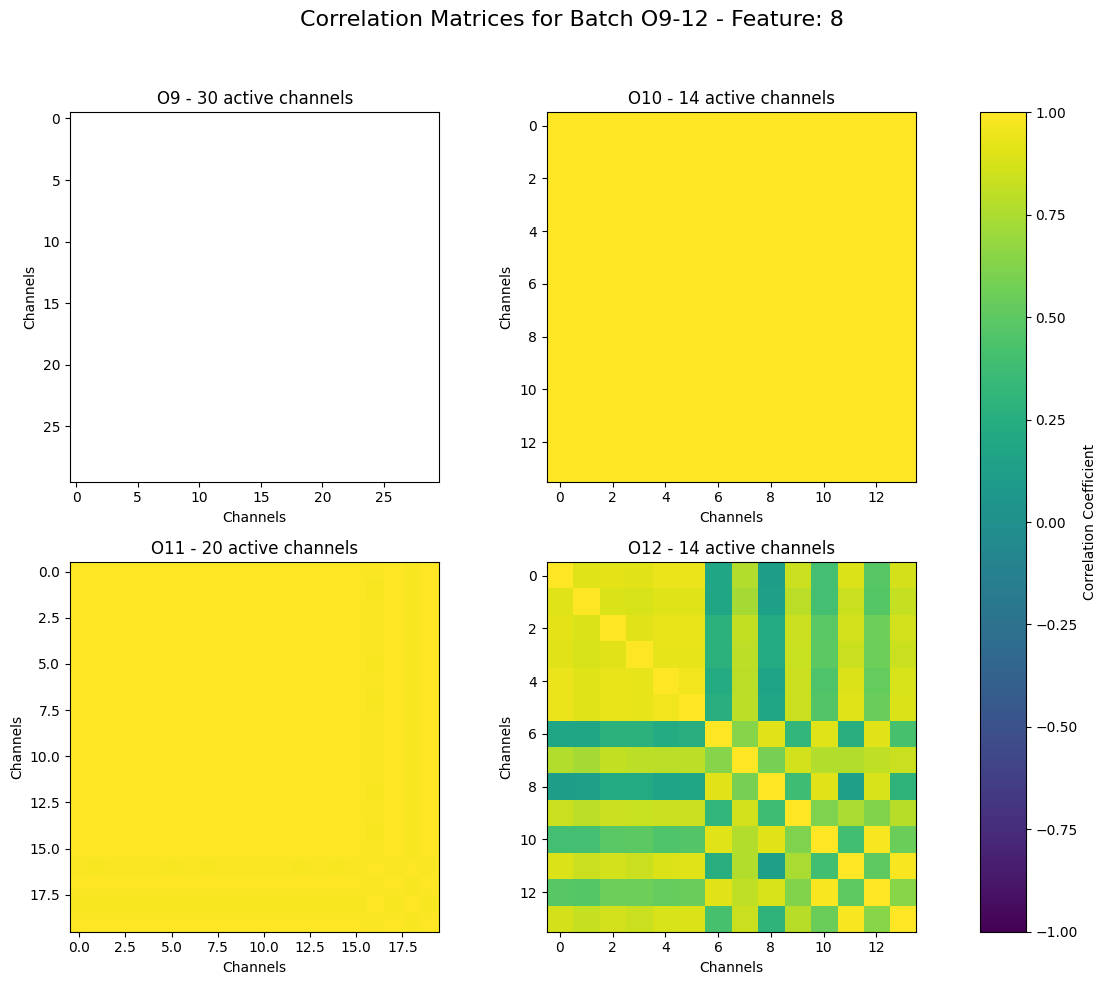

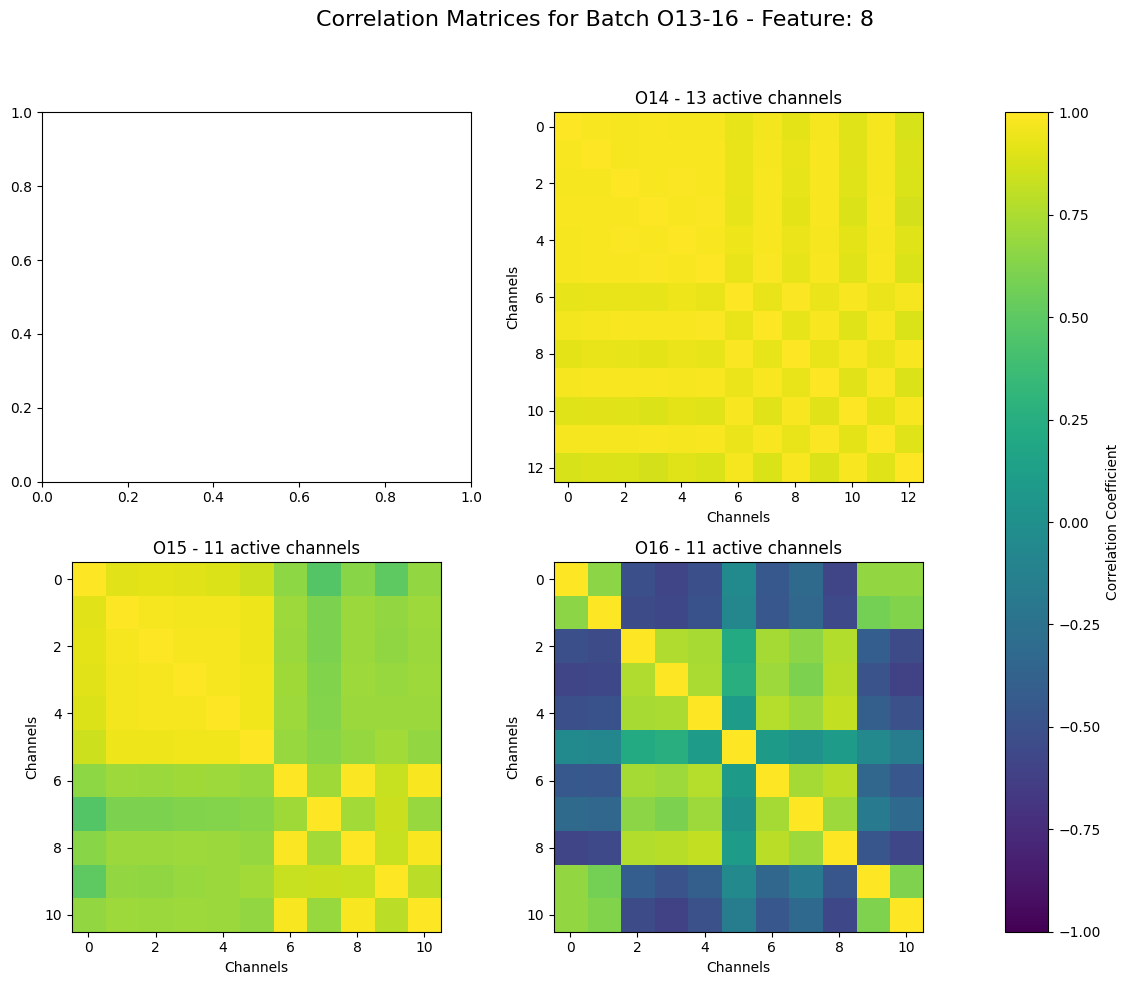

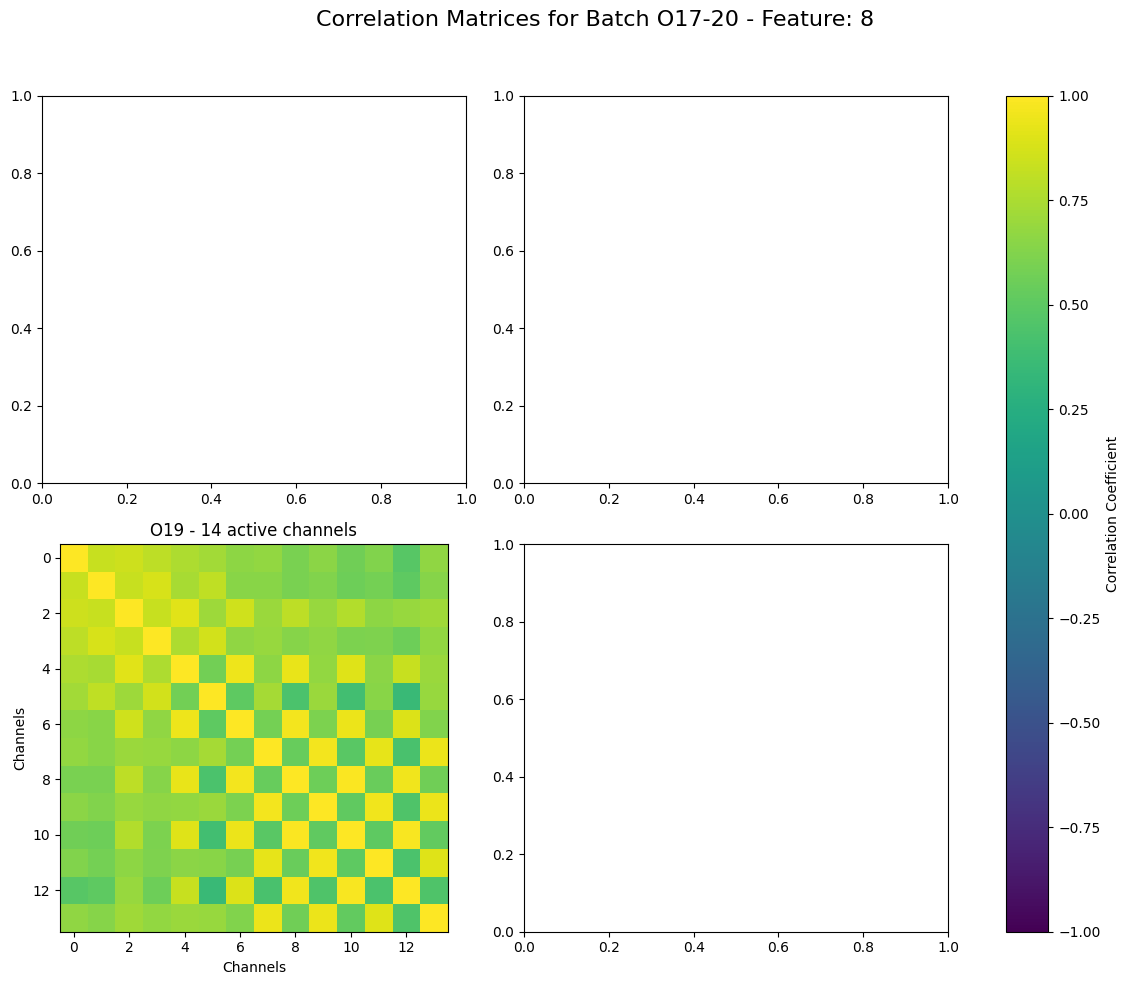

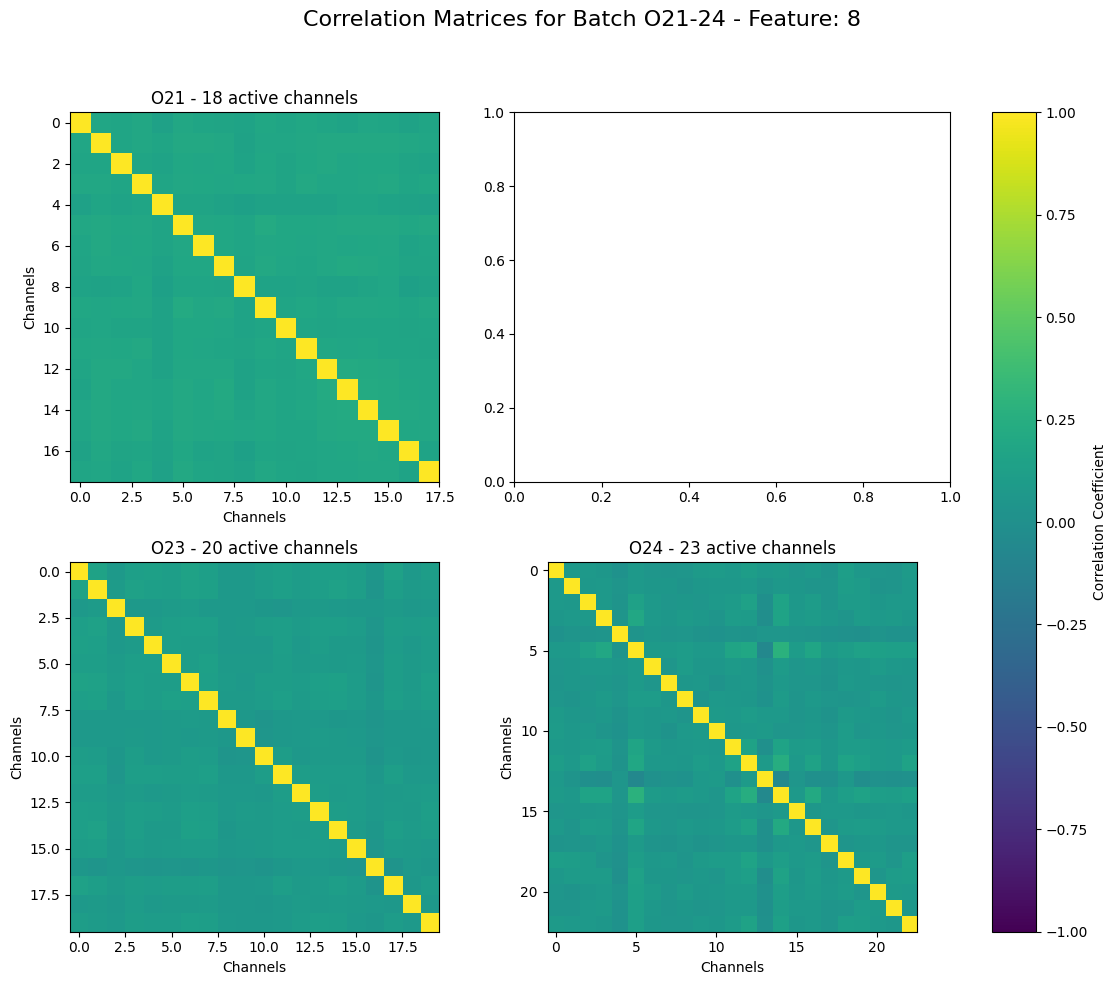

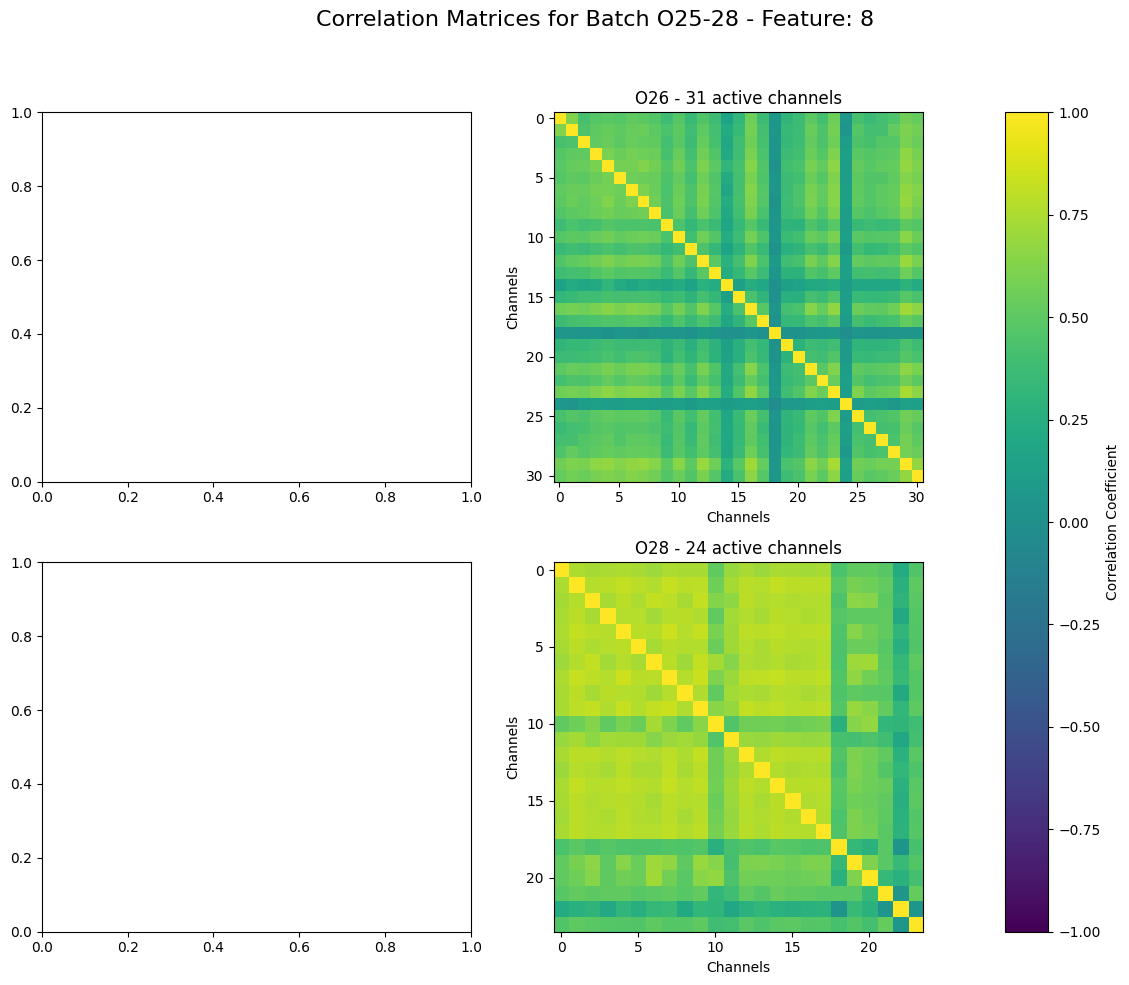

In [42]:
# Get Correlation coefficient matrix
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

feature_idx = 8 # [Delta, Theta, Alpha, Beta, Gamma, HG1, HG2, 35 uV, 4i uV, 5i uV]
corcoef_dict = {}

for batch, batch_dict in data.items():
    corcoef_dict[batch] = {}
    
    batch_data, batch_mask = batch_dict["Control"]
    # batch_data, batch_mask = batch_dict["Tetrodotoxin"]

    batch_data = batch_data[:,:,:,feature_idx]
    batch_mask = get_total_mask(batch_mask, rms=False)

    [O, C, T] = batch_data.shape # [num org, num channels, num min]
    org_ids = get_organoid_ids(batch)
    for o in range(O):
        org_data = apply_mask(batch_data[o,:,:], batch_mask[o,:,:])

        # find active channels (outside or impedance) (remove channels with no active time points)
        active_channels = ~(np.sum(~np.isnan(org_data), axis=1) == 0)
        org_data = org_data[active_channels, :]

        active_times = (np.sum(np.isnan(org_data), axis=0) == 0)
        org_data = org_data[:, active_times]

        # normalize data
        if org_data.shape[0] != 0:
            org_data = (org_data - np.mean(org_data, axis=1)[:, np.newaxis]) / np.std(org_data, axis=1)[:, np.newaxis]

        corcoef_dict[batch][org_ids[o]] = np.corrcoef(org_data)

# Create figures after all correlation matrices have been calculated
for batch, batch_dict in corcoef_dict.items():
    # Create a 2x2 figure for each batch with correlation matrices
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(2, 3, width_ratios=[1, 1, 0.1])  # 2x2 grid with extra column for colorbar

    # Get the number of organoids in this batch
    num_orgs = len(batch_dict)
    
    # Find global min and max for consistent colorbar
    vmin = -1
    vmax = 1
    
    # Create subplots for each organoid (up to 4 in a 2x2 grid)
    for i, (org_key, corr_matrix) in enumerate(batch_dict.items()):
        if i >= 4:  # Only show up to 4 organoids in the 2x2 grid
            break
            
        row = i // 2
        col = i % 2
        
        ax = fig.add_subplot(gs[row, col])
        if np.size(corr_matrix) > 5:
            im = ax.imshow(corr_matrix, cmap='viridis', vmin=vmin, vmax=vmax)
            ax.set_title(f'{org_key} - {corr_matrix.shape[0]} active channels')
            ax.set_xlabel('Channels')
            ax.set_ylabel('Channels')
        
    # Add a single colorbar for the entire figure
    cbar_ax = fig.add_subplot(gs[:, 2])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Correlation Coefficient')
    
    plt.suptitle(f'Correlation Matrices for Batch {batch} - Feature: {feature_idx}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.95, 0.95])  # Adjust layout to make room for the suptitle
    
    # Save or display the figure
    plt.show()



skipping O13: num_active_channels=0.0
skipping O17: num_active_channels=0.0
skipping O18: num_active_channels=0.0
skipping O20: num_active_channels=0.0
skipping O22: num_active_channels=0.0
skipping O25: num_active_channels=1.0
skipping O27: num_active_channels=0.0


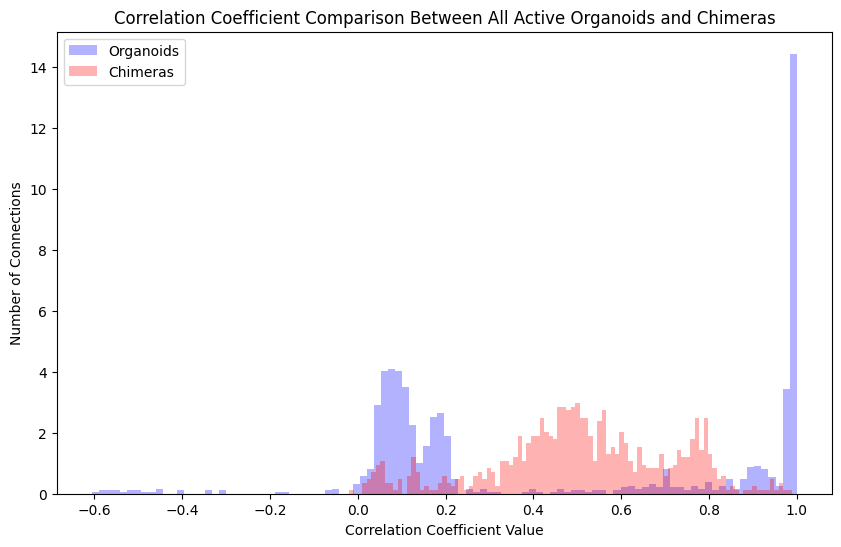

In [43]:
# correlation coefficient histograms

organoids = ["O9-12", "O13-16", "O21-24"]
org_values = []
chimera_values = []

for batch, batch_dict in corcoef_dict.items():
    
    is_organoid = batch in organoids

    for org, corr in batch_dict.items():

        if corr.size < 5^2: # at least 5 active channels
            print(f"skipping {org}: num_active_channels={np.sqrt(corr.size)}")
            continue

        corr_values = corr[np.triu_indices(corr.shape[0], k=1)]

        if is_organoid:
            org_values.extend(list(corr_values))
        else:
            chimera_values.extend(list(corr_values))

plt.figure(figsize=(10, 6))
plt.hist(org_values, bins=100, alpha=.3, label="Organoids", color='b', density=True)
plt.hist(chimera_values, bins=100, alpha=.3, label="Chimeras", color='r', density=True)

plt.legend()
plt.title('Correlation Coefficient Comparison Between All Active Organoids and Chimeras')
plt.xlabel('Correlation Coefficient Value')
plt.ylabel('Number of Connections')
plt.show()

In [44]:
def get_asterisks(p_value):

    if p_value <= .0001:
        return "****"
    
    elif p_value <= .001:
        return "***"
    
    elif p_value <= .01:
        return "**"
    
    elif p_value <= .05:
        return "*"
    
    else:
        return ""

C:\Users\Organoid PC\AppData\Local\Temp\ipykernel_12140\3468100888.py:51: UserWarning: Adding colorbar to a different Figure <Figure size 1200x1000 with 5 Axes> than <Figure size 800x900 with 3 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(im, cax=cbar_ax)


Text(0.6, 0.95, 'Correlation Coefficient Map')

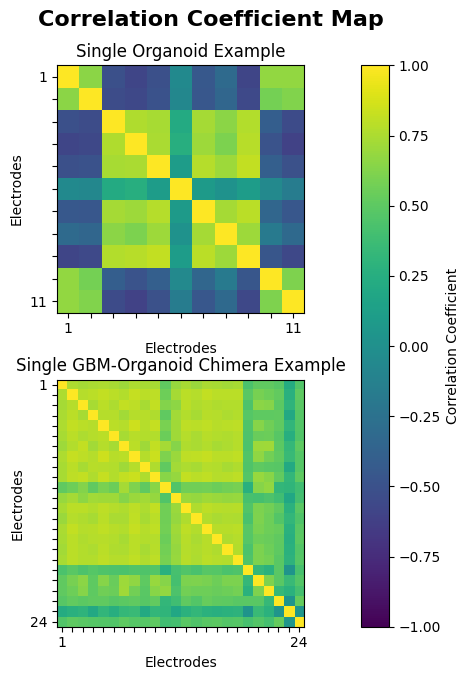

In [45]:
# Create a correlation matrix plot example for organoids and chimeras (2x1)

# organoid example
org_batch = "O13-16"
org_idx = "O16"

# chimera example 
chim_batch = "O25-28"
chim_idx = "O28"

# generate figure
fig = plt.figure(figsize=(8, 9))
gs = GridSpec(2, 2, width_ratios=[1, 0.05])  # 2x2 grid with extra column for colorbar

# colorbar min/max
vmin = -1
vmax = 1

# plot organoid map
org_matrix = corcoef_dict[org_batch][org_idx]
num_channels_o = org_matrix.shape[0]

ax_o = fig.add_subplot(gs[0,0])
im_o = ax_o.imshow(org_matrix, cmap='viridis', vmin=vmin, vmax=vmax)

ax_o.set_title("Single Organoid Example")
ax_o.set_xlabel("Electrodes")
ax_o.set_ylabel("Electrodes")
ax_o.set_xticks(list(range(num_channels_o)))
ax_o.set_yticks(list(range(num_channels_o)))
ax_o.set_xticklabels([1] + [""]*(num_channels_o-2) + [num_channels_o])
ax_o.set_yticklabels([1] + [""]*(num_channels_o-2) + [num_channels_o])

# plot chimera map
chim_matrix = corcoef_dict[chim_batch][chim_idx]
num_channels_c = chim_matrix.shape[0]

ax_c = fig.add_subplot(gs[1,0])
im_c = ax_c.imshow(chim_matrix, cmap='viridis', vmin=vmin, vmax=vmax)

ax_c.set_title("Single GBM-Organoid Chimera Example")
ax_c.set_xlabel("Electrodes")
ax_c.set_ylabel("Electrodes")
ax_c.set_xticks(list(range(num_channels_c)))
ax_c.set_yticks(list(range(num_channels_c)))
ax_c.set_xticklabels([1] + [""]*(num_channels_c-2) + [num_channels_c])
ax_c.set_yticklabels([1] + [""]*(num_channels_c-2) + [num_channels_c])

# add colorbar
cbar_ax = fig.add_subplot(gs[:, 1])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Correlation Coefficient', loc='center')

# figure layout stuff
fig.tight_layout(rect=[.2, .2, 0.93, 0.93], h_pad=.1)
fig.suptitle("Correlation Coefficient Map",             
             x=0.6,            # centered horizontally
             y=0.95,           # slightly lower than default
             fontsize=16,      # larger text
             fontweight='bold',# bold text
             
)         



skipping O13: num_active_channels=0.0
skipping O25: num_active_channels=1.0
skipping O27: num_active_channels=0.0


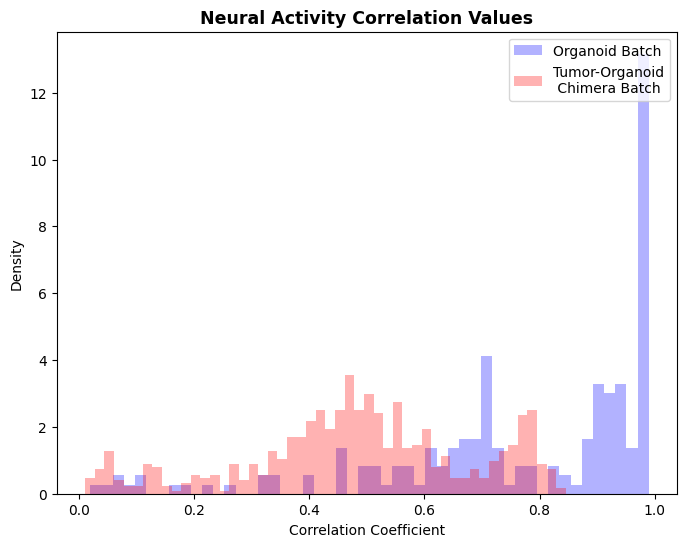

In [46]:
# Batch Histogram Corr coeff organoids vs chimeras

# plot batches
org_batch = "O13-16"
chim_batch = "O25-28"

# get data
org_data = []
for org_id, corr_matrix in corcoef_dict[org_batch].items():
        
    if corr_matrix.size < 5^2: # at least 5 active channels
        print(f"skipping {org_id}: num_active_channels={np.sqrt(corr_matrix.size)}")
        continue

    corr_values = corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)]
    org_data.extend(corr_values)

chim_data = []
for chim_id, corr_matrix in corcoef_dict[chim_batch].items():

    if corr_matrix.size < 5^2: # at least 5 active channels
        print(f"skipping {chim_id}: num_active_channels={np.sqrt(corr_matrix.size)}")
        continue

    corr_values = corr_matrix[np.triu_indices(corr_matrix.shape[0], k=1)]
    chim_data.extend(corr_values)

# Run Statistical Tests
# Run KS test on the two distributions
ks_stat, ks_p_value = scipy.stats.ks_2samp(org_data, chim_data)
u_stat, u_p_value = scipy.stats.mannwhitneyu(org_data, chim_data)


# plot data
plt.figure(figsize=(8,6))
plt.hist(np.abs(org_data), bins=50, alpha=.3, label="Organoid Batch", color='b', density=True)
plt.hist(np.abs(chim_data), bins=50, alpha=.3, label="Tumor-Organoid\n Chimera Batch", color='r', density=True)
plt.title('Neural Activity Correlation Values', fontsize=12.5, fontweight='bold')# bold text)
plt.xlabel("Correlation Coefficient")
plt.ylabel("Density")
plt.legend(loc='upper right')

# plt.text(.75,11, f"{get_asterisks(ks_p_value)}KS Test p-value: {np.round(ks_p_value, decimals=3)} \n {get_asterisks(u_p_value)}U Test p-value: {np.round(u_p_value, decimals=3)}")


In [47]:
# Statistical Analysis
from scipy import stats

# Run KS test on the two distributions
ks_stat, p_value = stats.ks_2samp(org_data, chim_data)

print(f"KS statistic: {ks_stat}")
print(f"p-value: {p_value}")
print(f"Distributions are {'significantly different' if p_value < 0.05 else 'not significantly different'}")

KS statistic: 0.5567806586843541
p-value: 1.1786283811969623e-43
Distributions are significantly different


In [48]:
u_stat, p_value = stats.mannwhitneyu(org_data, chim_data)

print(f"Mann-Whitney U statistic: {u_stat}")
print(f"p-value: {p_value}")
print(f"Distributions are {'significantly different' if p_value < 0.05 else 'not significantly different'}")

Mann-Whitney U statistic: 106794.0
p-value: 1.2668108762187027e-29
Distributions are significantly different


In [49]:
# Make Session Dict andd Get Data
batch_ids = ["O9-12", "O13-16", "O17-20", "O21-24", "O25-28"]
drug_names = ["Control", "4-AP", "No Drug", "Bicuculline", "Tetrodotoxin"]

session = make_session_dict(
    batch_ids=batch_ids, 
    drug_names=drug_names,
    start_delay=datetime.timedelta(minutes=5),
    length=datetime.timedelta(hours=3)
    )

# rename Control to Control 1 (at start of experiment)
for batch_id, batch_dict in session.items():
    batch_dict["Control 1"] = batch_dict.pop("Control")

    # create Control 2 right before 4-AP introduciton
    cntrl2_st = batch_dict["4-AP"][0] - datetime.timedelta(hours=4)
    cntrl2_et = cntrl2_st + datetime.timedelta(hours=3)
    batch_dict["Control 2"] = (cntrl2_st, cntrl2_et)

    # reorder dictionary
    order = ["Control 1", "Control 2", "4-AP", "No Drug", "Bicuculline", "Tetrodotoxin"]
    session[batch_id] = {k: batch_dict[k] for k in order}

In [50]:
processed_data_dir = os.path.join(os.getcwd(), "processed_data")
data = get_data_dict(session, processed_data_dir)

O9-12:
Control 1:
Processing 230503.npz
181/1440 minutes sucessfully recorded
86.56% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
5.3% of data pass all filters

Control 2:
Processing 230518.npz
181/1440 minutes sucessfully recorded
67.28% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
3.43% of data pass all filters

4-AP:
Processing 230518.npz
181/1440 minutes sucessfully recorded
65.56% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
3.33% of data pass all filters

No Drug:
Processing 230518.npz
181/1440 minutes sucessfully recorded
66.09% of data in valid rms range
0/128 electrodes inside organoids
0/128 electrodes in valid impedance range
3.34% of data pass all filters

Bicuculline:
Processing 230519.npz
181/1440 minutes sucessfully recorded
65.69% of data in valid rms range
0/128 electrodes inside organoids
0/128 el

In [51]:
# Get correlation vlaues (average of top diagnol of crorelation matrix)

feature_idx = 8 # [Delta, Alpha, Beta, Theta, Gamma, HG1, HG2, 35 uV, 4i uV, 5i uV]
corr_dict = {}

tbin = 10 # min

for batch, batch_dict in data.items():
    
    drug_list = []
    t = None
    drug_idx = []
    for drug, drug_dict in batch_dict.items():
        
        # extract data
        drug_data, drug_mask = drug_dict

        drug_data = drug_data[:,:,:,feature_idx]
        drug_mask = get_total_mask(drug_mask, rms=False)

        # remove times with no recording
        active_times = ~(np.sum(drug_mask, axis=(0,1)) == 0)
        drug_data = drug_data[:,:,active_times]
        drug_mask = drug_mask[:,:,active_times]

        [O, C, T] = drug_data.shape
        org_ids = get_organoid_ids(batch)
        I = T // tbin

        corr_array = np.full((O,I), np.nan)
        if t is None:
            t = list(range(I))
        else:
            t_end = t[-1]+1
            t.extend(range(t_end, t_end+I))
        drug_idx.append(t[-1])

        for o in range(O):
            org_data = apply_mask(drug_data[o,:,:], drug_mask[o,:,:])

            # find active channels (outside or impedance) (remove channels with no active time points)
            active_channels = ~(np.sum(~np.isnan(org_data), axis=1) == 0)
            org_data = org_data[active_channels, :]

            # minimum of 5 actvie channels to include
            if org_data.shape[0] < 5:
                continue

            for i in range(I):
                bin_idx = np.arange(tbin*(i),tbin*(i+1))
                bin_data = org_data[:,bin_idx]

                # get correlation matrix
                correlation_matrix = np.corrcoef(bin_data)

                # get correlation values
                corr_values = correlation_matrix[np.triu_indices(correlation_matrix.shape[0], k=1)]

                # store mean of correlation values
                corr_array[o, i] = np.mean(np.abs(corr_values))
        drug_list.append(corr_array)
        batch_array = np.concatenate(drug_list, axis=1)

        corr_dict[batch] = (t, batch_array, drug_idx)

        

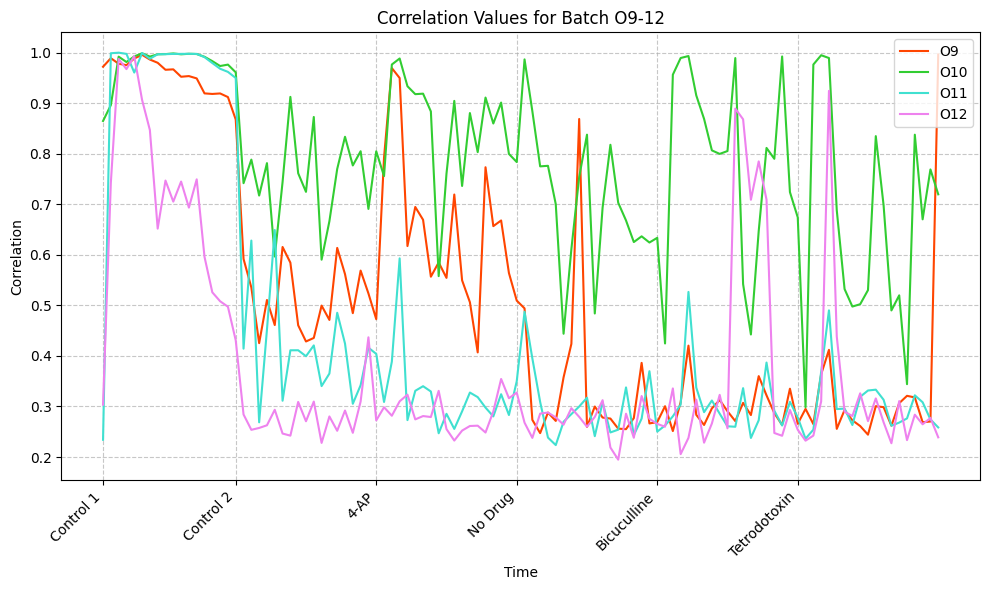

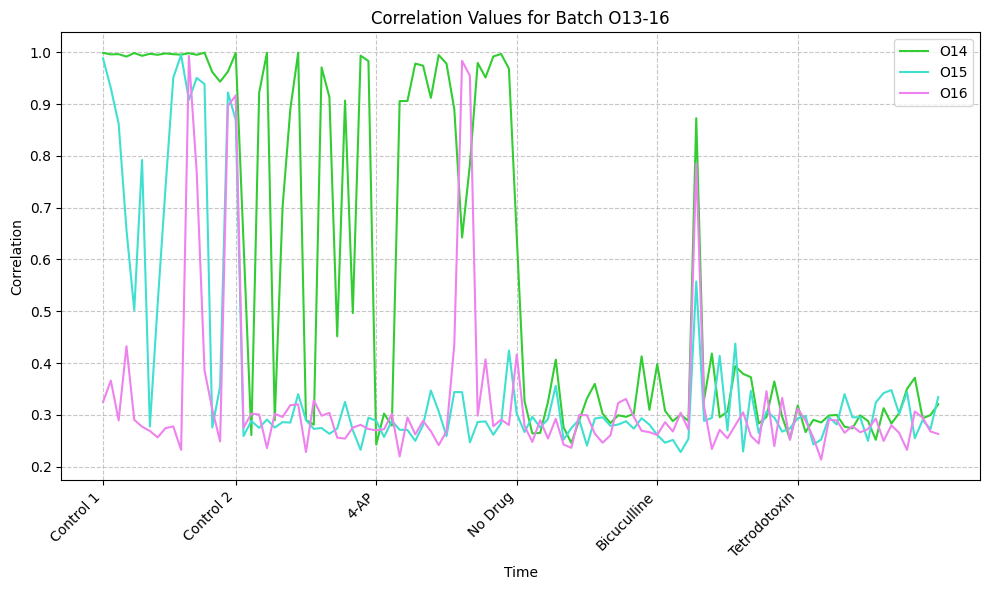

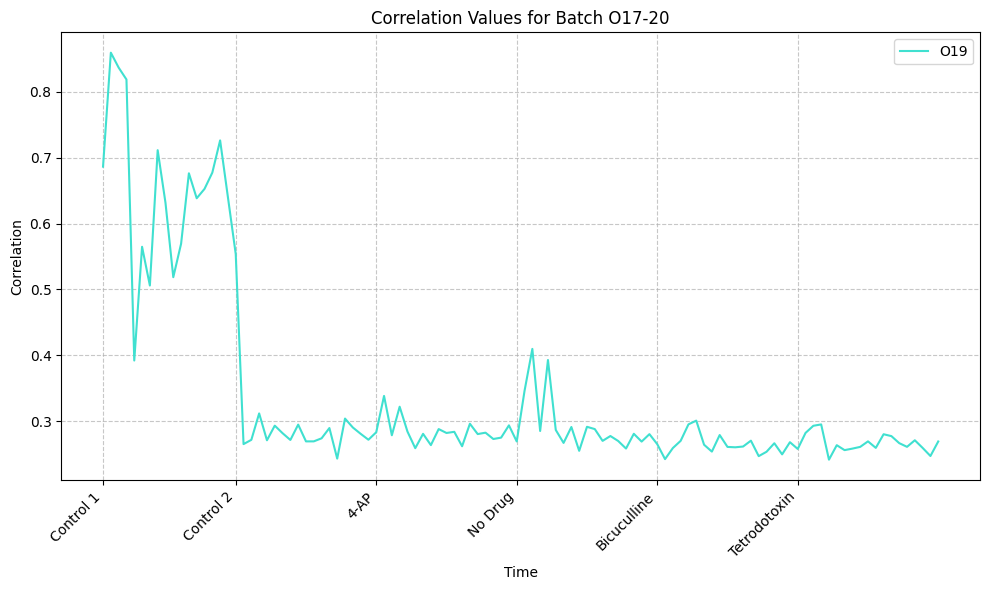

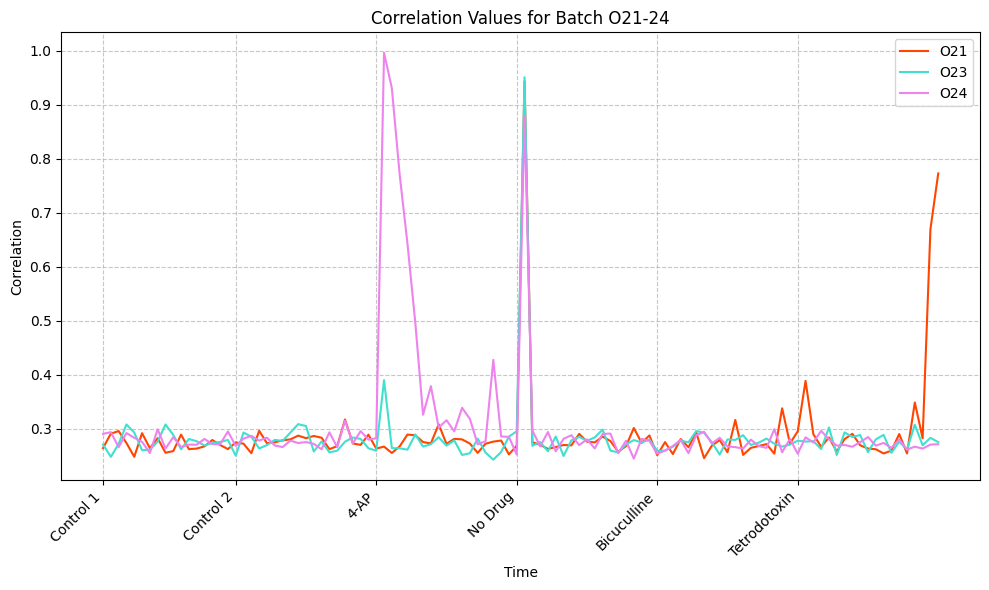

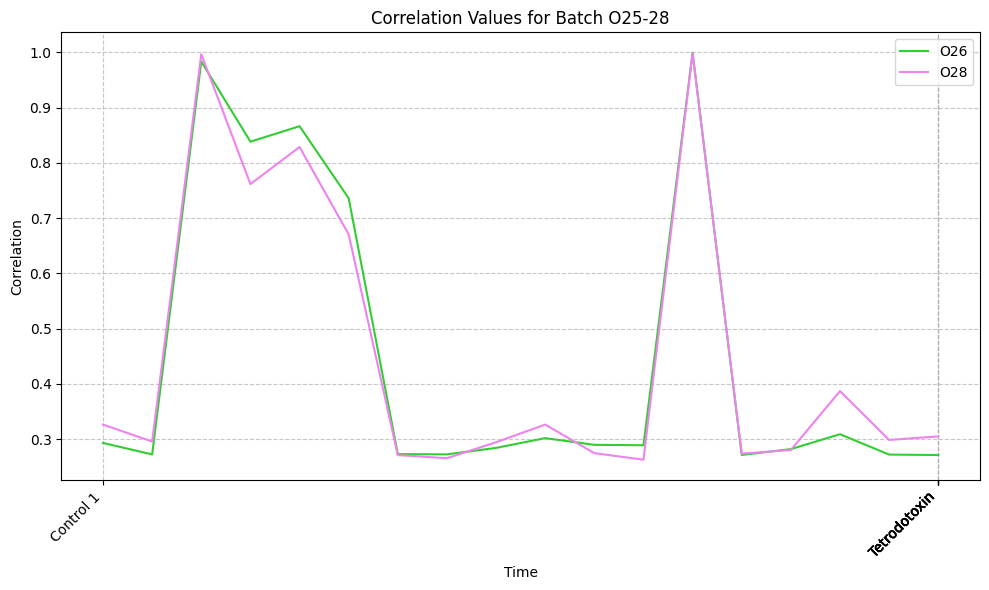

In [52]:
# Plot Correlation Values (time vs correlation) (figure per batch, line per organoid)
colors = ['orangered', 'limegreen', 'turquoise', 'violet']
d_labels = ["Control 1", "Control 2", "4-AP", "No Drug", "Bicuculline", "Tetrodotoxin"]

for batch, (t, plot_data, d_idx) in corr_dict.items():
    d_idx = [0] + d_idx[:-1]  # add 0 remove last value
    
    org_ids = get_organoid_ids(batch)

    plt.figure(figsize=(10, 6))  # Create a new figure for each batch
    
    for o, org_id in enumerate(org_ids):
        org_data = plot_data[o, :]

        # skip nan values (invalid organoids)
        if np.isnan(np.sum(org_data)):
            continue

        plt.plot(t, org_data, color=colors[o], label=org_id)

    plt.xlabel('Time')
    plt.ylabel('Correlation')
    plt.title(f'Correlation Values for Batch {batch}')
    plt.legend()

    # Set x-axis ticks and labels
    plt.xticks(d_idx, d_labels, rotation=45, ha='right')

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()



In [53]:
[O, C, T] = batch_data.shape # [num org, num channels, num min]
org_ids = get_organoid_ids(batch)
for o in range(O):
    org_data = apply_mask(batch_data[o,:,:], batch_mask[o,:,:])

    # find active channels (outside or impedance) (remove channels with no active time points)
    active_channels = ~(np.sum(~np.isnan(org_data), axis=1) == 0)
    org_data = org_data[active_channels, :]

    active_times = (np.sum(np.isnan(org_data), axis=0) == 0)
    org_data = org_data[:, active_times]
    print(org_data.shape[1])
    # minimum of 5 actvie channels to include
    if org_data.shape[0] < 5:
        print(f"skipping {org_ids[o]}, only {org_data.shape[0]} active channels")
        continue
    
    # get correlation matrix
    correlation_matrix = np.corrcoef(org_data)

    # get correlation values
    corr_values = correlation_matrix[np.triu_indices(correlation_matrix.shape[0], k=1)]

2854
skipping O25, only 1 active channels
2854
11520
skipping O27, only 0 active channels
2854


In [68]:
# Filter Line Plots (time vs valid channels)

# input = 2 layer dict [batch, days]
# output = 4x1 figure (each organoid) with drug conditions labeled on x-axis

# make session dict
batch_ids = ["O9-12", "O13-16", "O17-20", "O21-24", "O25-28"]

session = {}
for batch_id in batch_ids:
    session[batch_id] = {}

    recording_start = get_drug_times(batch_id, "Control")[0]
    recording_end = get_drug_times(batch_id, "Tetrodotoxin")[1]

    # Iterate through the range of dates
    date_list = []
    date = recording_start.date()
    while date <= recording_end.date():
        # Append the date part of the datetime object to the list
        date_list.append(date)
        # Increment the current datetime by one day
        date += datetime.timedelta(days=1)
    
    for date in date_list:

        if date == date_list[0]:
            session[batch_id][date] = (recording_start, recording_start+datetime.timedelta(minutes=1))

        elif date == date_list[-1]:
            session[batch_id][date] = (recording_end-datetime.timedelta(minutes=1), recording_end)

        else:
            session[batch_id][date] = (datetime.datetime.combine(date, datetime.time(hour=2, minute=0)), datetime.datetime.combine(date, datetime.time(hour=2, minute=1)))

In [69]:
impedance_data = get_data_dict(session, processed_data_dir, return_value="impedance")

O9-12:
2023-05-03:
Processing 230503.npz
2023-05-04:
Processing 230504.npz
2023-05-05:
Processing 230505.npz
2023-05-06:
Processing 230506.npz
2023-05-07:
Processing 230507.npz
2023-05-08:
Processing 230508.npz
2023-05-09:
Processing 230509.npz
2023-05-10:
Processing 230510.npz
2023-05-11:
Processing 230511.npz
2023-05-12:
Processing 230512.npz
2023-05-13:
Processing 230513.npz
2023-05-14:
Processing 230514.npz
2023-05-15:
Processing 230515.npz
2023-05-16:
Processing 230516.npz
2023-05-17:
Processing 230517.npz
2023-05-18:
Processing 230518.npz
2023-05-19:
Processing 230519.npz
O13-16:
2023-05-25:
Processing 230525.npz
2023-05-26:
Processing 230526.npz
2023-05-27:
Processing 230527.npz
2023-05-28:
Processing 230528.npz
2023-05-29:
Processing 230529.npz
2023-05-30:
Processing 230530.npz
2023-05-31:
Processing 230531.npz
2023-06-01:
Processing 230601.npz
2023-06-02:
Processing 230602.npz
2023-06-03:
Processing 230603.npz
2023-06-04:
Processing 230604.npz
2023-06-05:
Processing 230605.npz

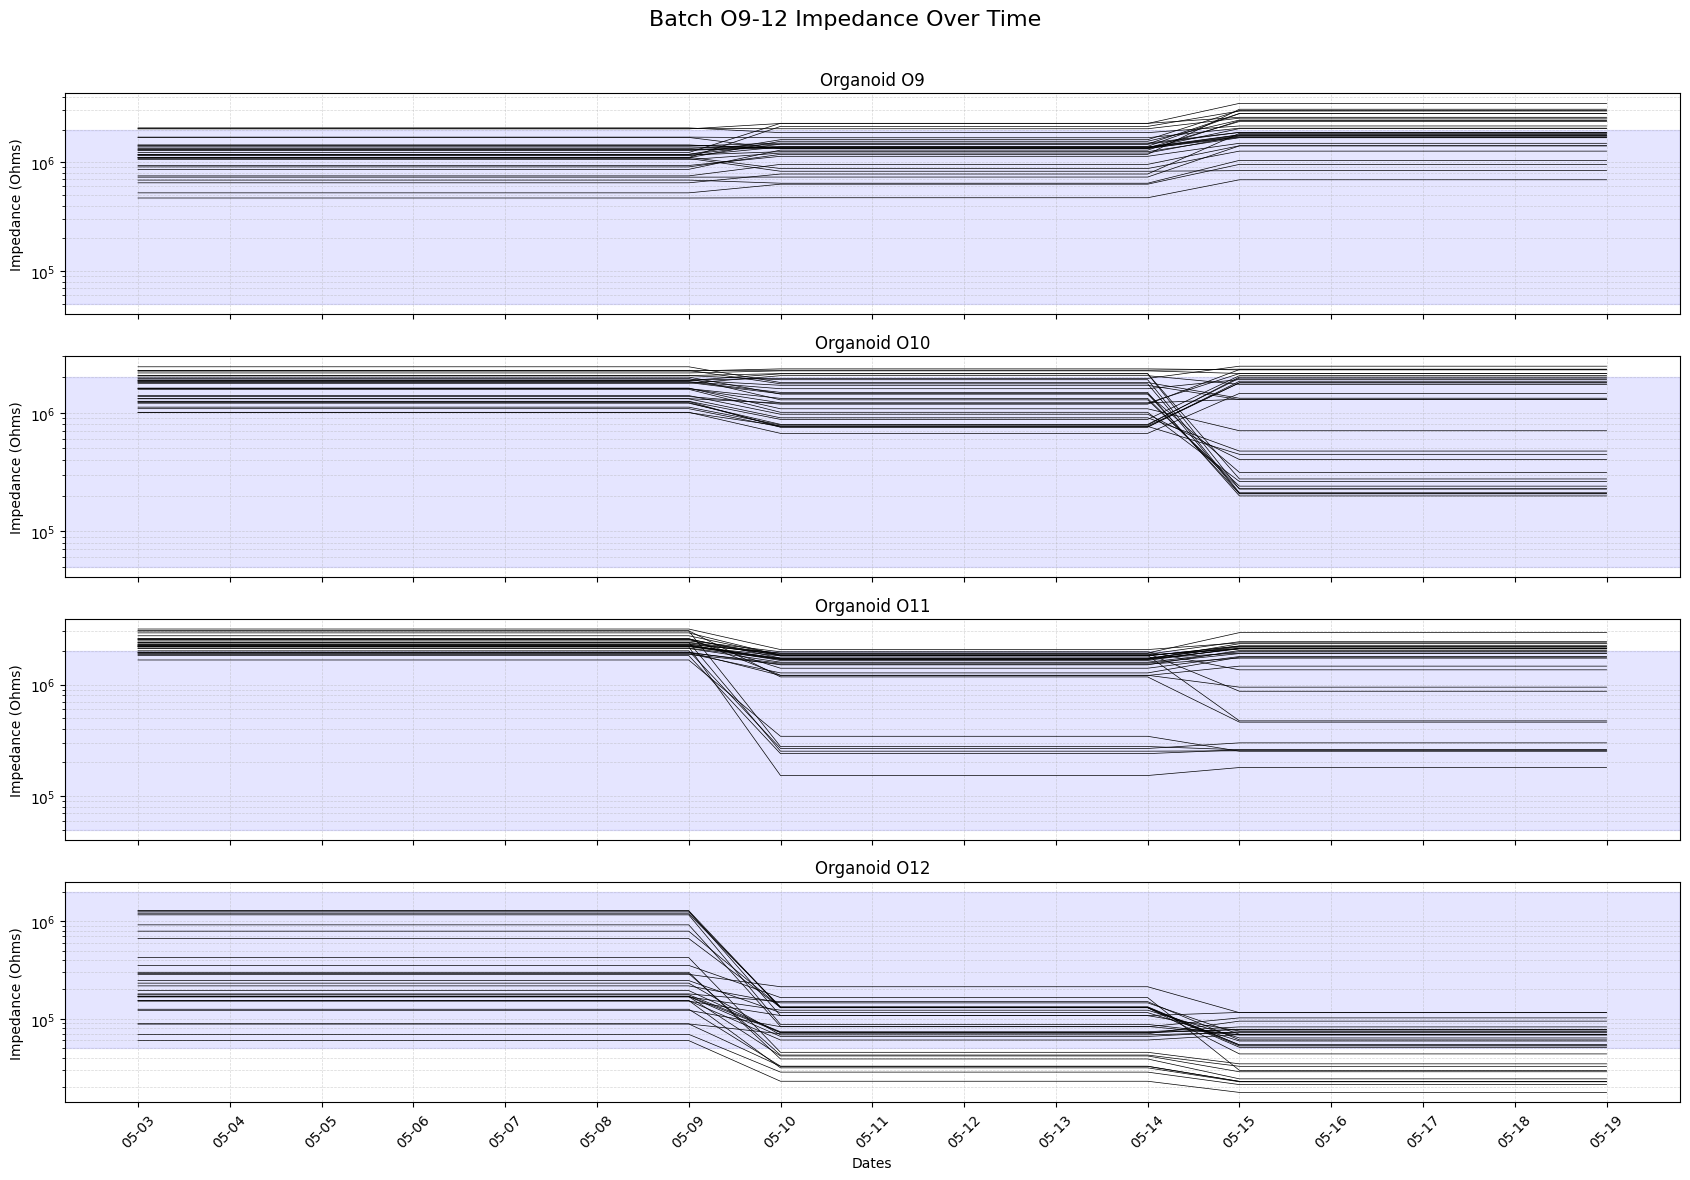

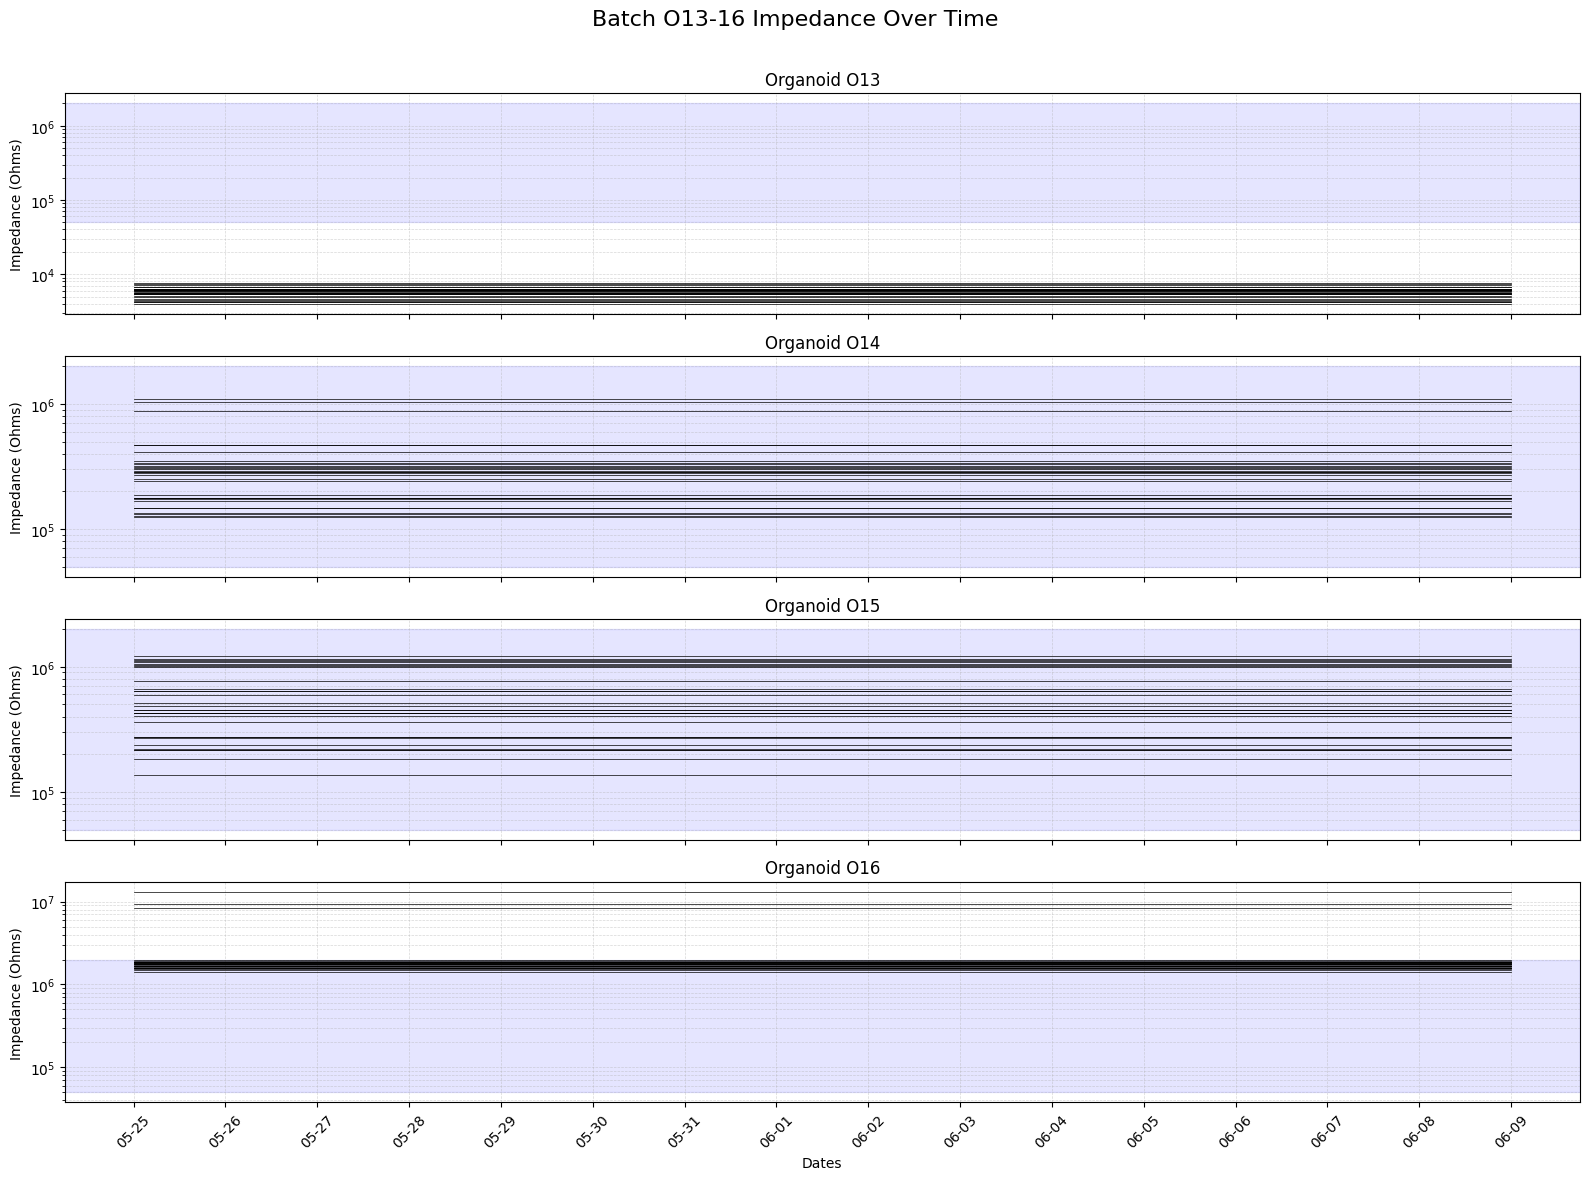

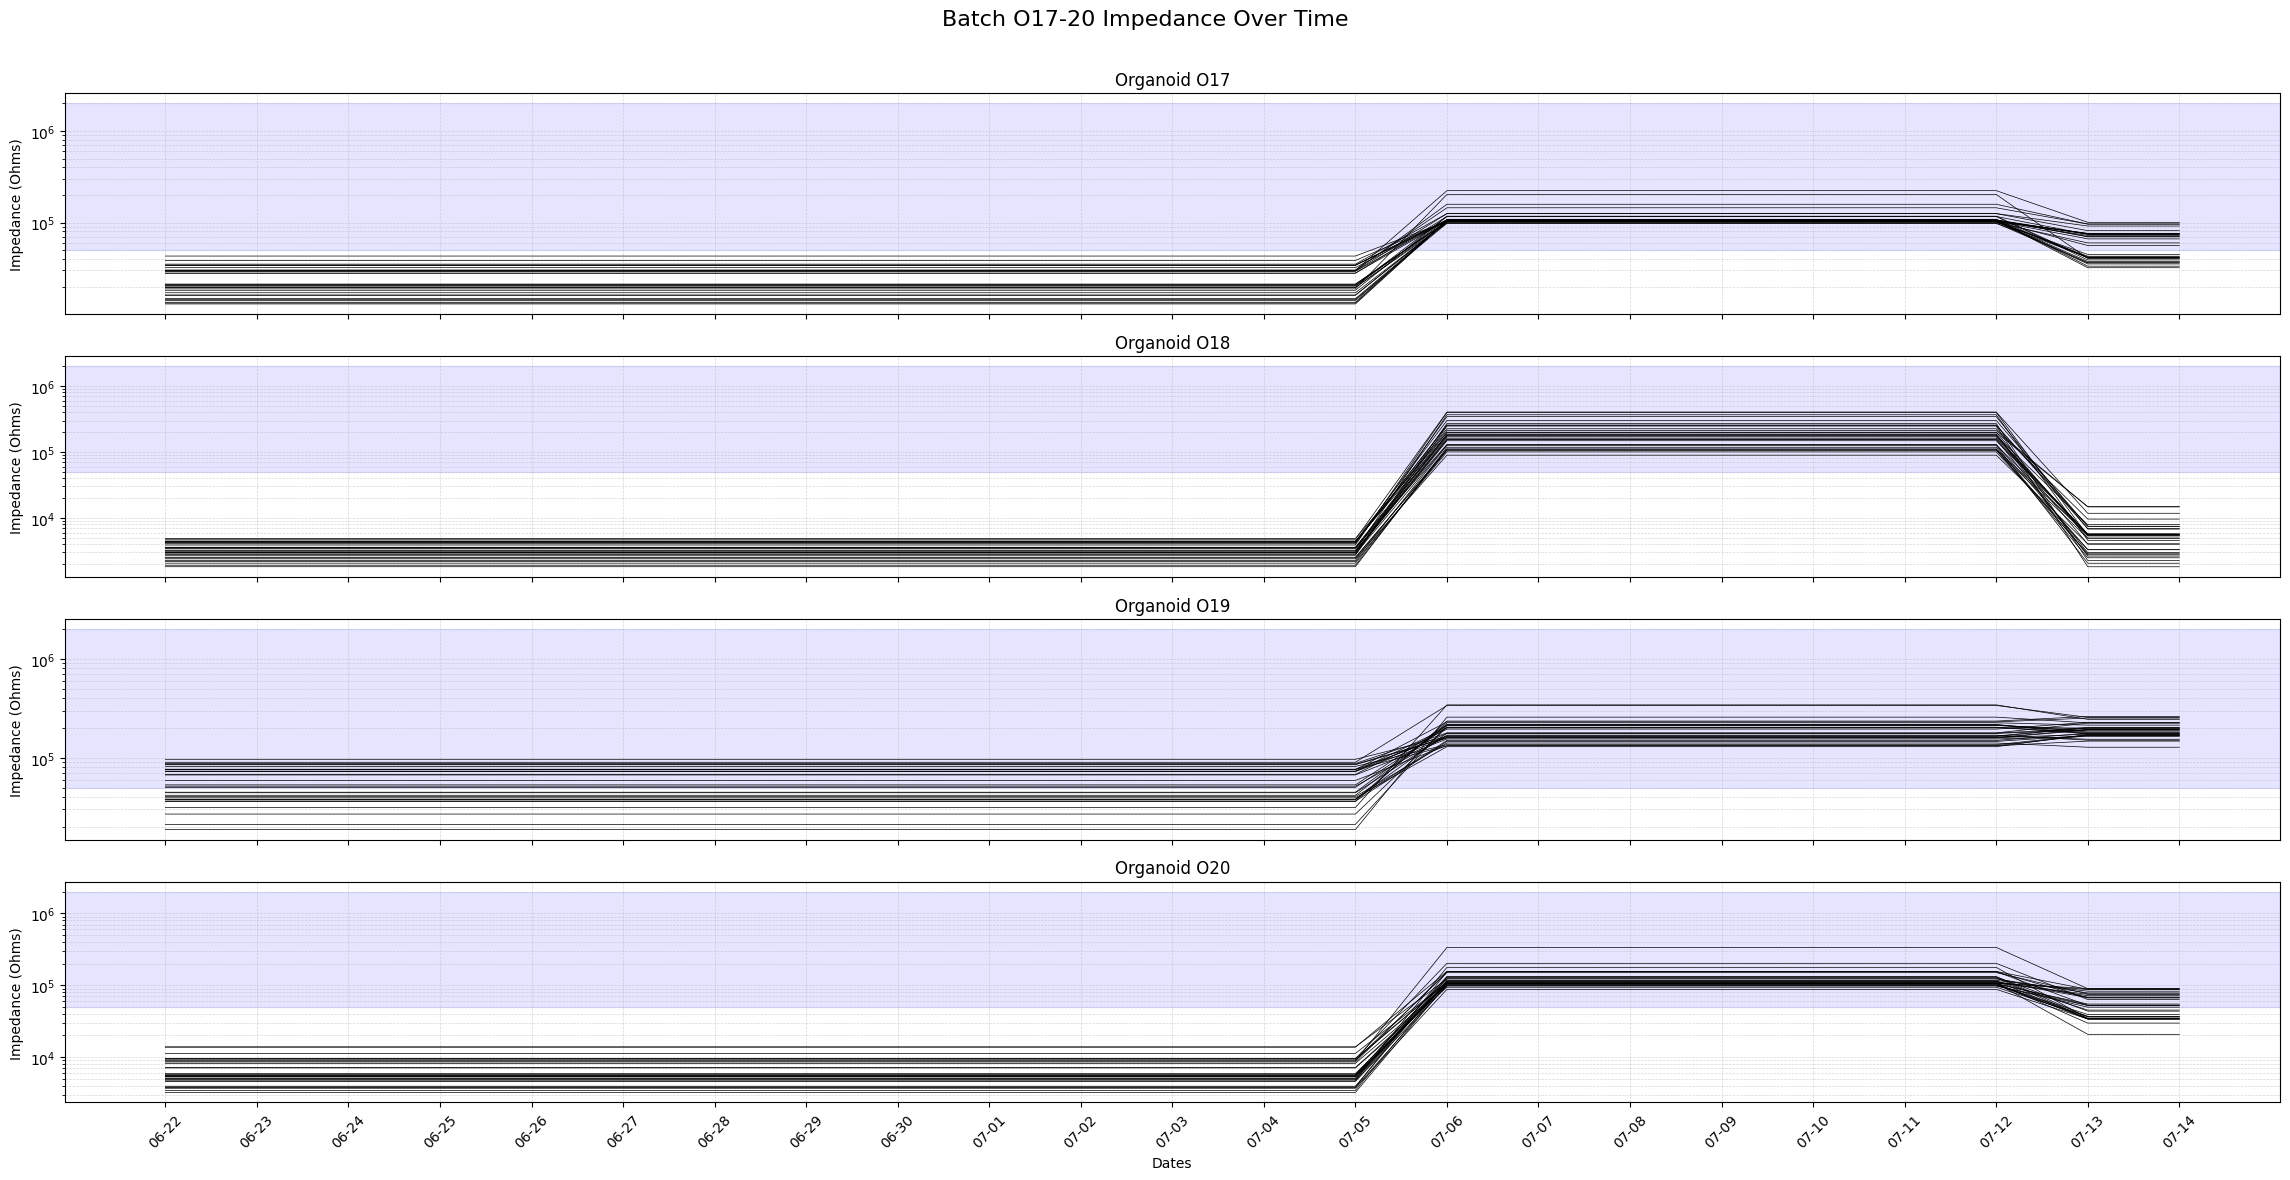

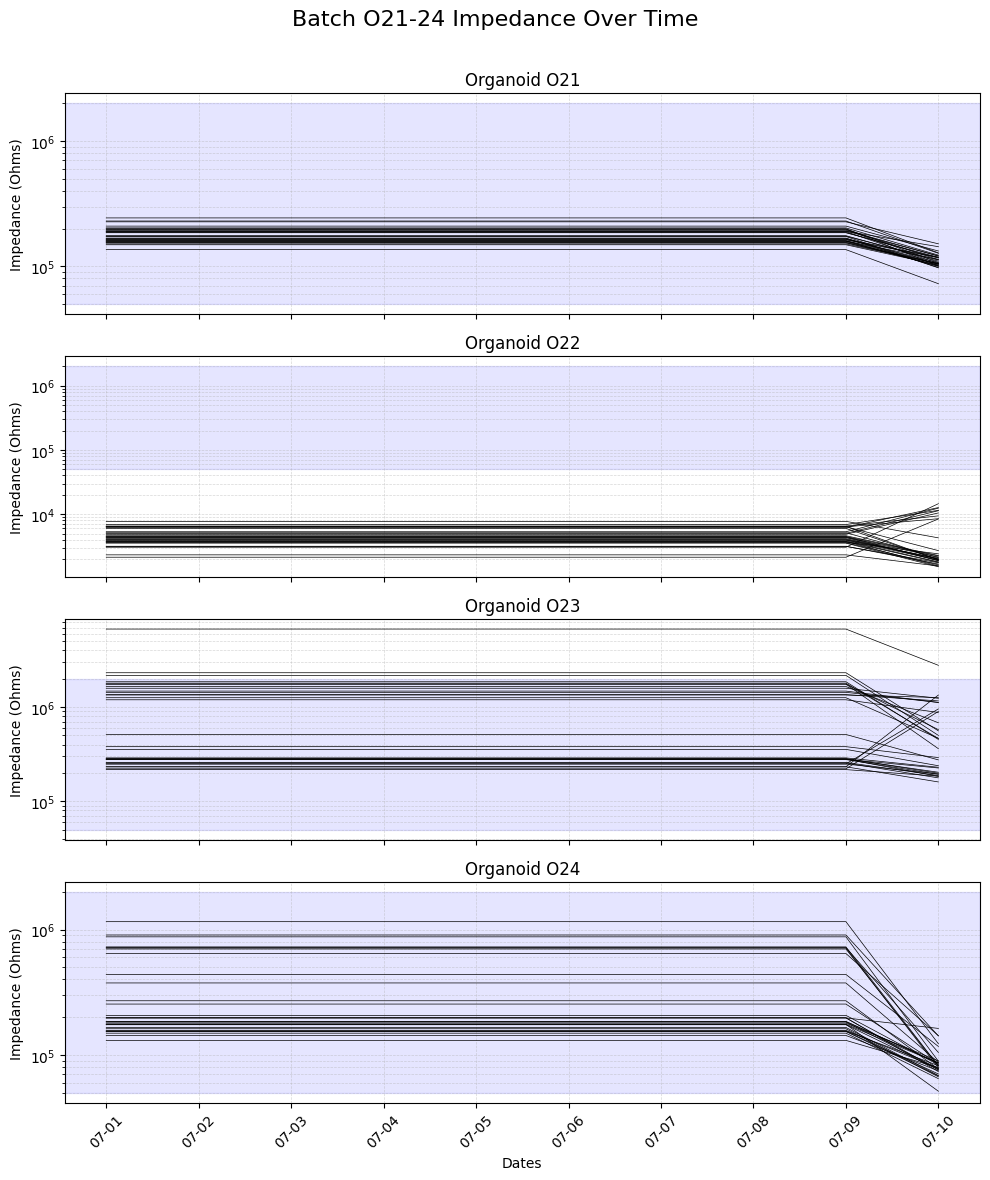

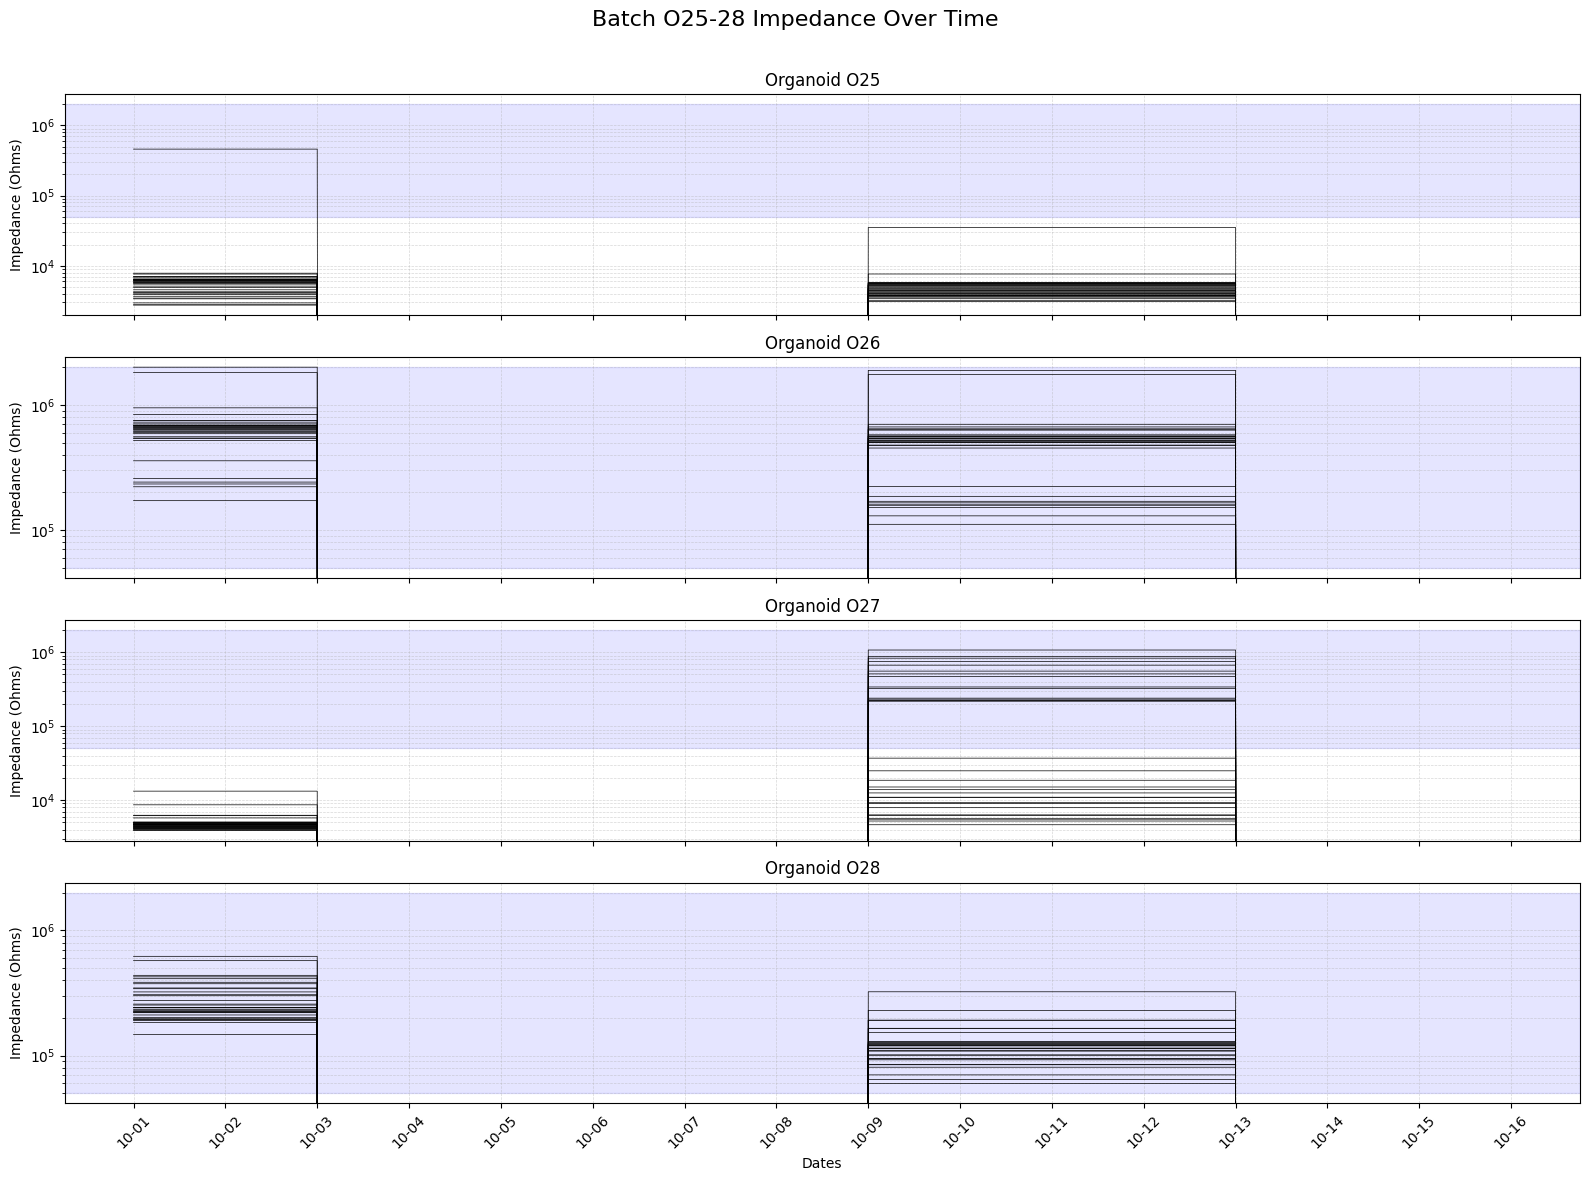

In [64]:
xlabel = "Dates"
ylabel = "Impedance (Ohms)"

linecolor = "k"
linewidth = .5
yscale = "log"

I1 = 50000
I2 = 2000000
shadecolor = "b"
shade_alpha = 0.1  # Transparency for shaded region

for batch_id, batch_dict in impedance_data.items():
    organoids = get_organoid_ids(batch_id)  # List of 4 organoid IDs
    
    # Sort dates to ensure proper x-axis order
    dates = sorted(batch_dict.keys())
    xticklabels = [date.strftime("%m-%d") for date in dates]
    num_dates = len(dates)
    
    # Stack all impedance values for this batch into a 4x32xN array
    impedance_all = np.stack([batch_dict[date][:,:,0] for date in dates], axis=-1)  # shape: (4, 32, N)
    
    fig, axs = plt.subplots(4, 1, figsize=(num_dates*1, 12), sharex=True)
    fig.suptitle(f"Batch {batch_id} Impedance Over Time", fontsize=16)
    
    for i in range(4):  # For each organoid
        ax = axs[i]
        for ch in range(32):
            ax.plot(
                range(num_dates), 
                impedance_all[i, ch, :], 
                color=linecolor, 
                linewidth=linewidth
            )
        
        # Add shaded region
        ax.axhspan(I1, I2, color=shadecolor, alpha=shade_alpha)
        
        ax.set_yscale(yscale)
        ax.set_ylabel(ylabel)
        ax.set_title(f"Organoid {organoids[i]}")
        ax.grid(True, which='both', ls='--', lw=0.5, alpha=0.5)
    
    axs[-1].set_xticks(range(num_dates))
    axs[-1].set_xticklabels(xticklabels, rotation=45)
    axs[-1].set_xlabel(xlabel)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for suptitle
    plt.show()





# Filter Electrodes and Times



In [76]:
# Get Data
# make session dict
batch_ids = ["O9-12", "O13-16", "O17-20", "O21-24", "O25-28"]

session = {}
for batch_id in batch_ids:
    
    recording_start = get_drug_times(batch_id, "Control")[0]
    recording_end = get_drug_times(batch_id, "Tetrodotoxin")[1]

    session[batch_id] = (recording_start, recording_end)

impedance_data = get_data_dict(session, processed_data_dir, return_value="impedance")
rms_data = get_data_dict(session, processed_data_dir, return_value="rms")

data = {
    "impedance": impedance_data,
    "rms": rms_data,
}

masks = {} # minute mask / rms mask / inside mask / impedance mask
feature_data = {}
for batch_id, batch_data in get_data_dict(session, processed_data_dir).items():
    feature_data[batch_id] = batch_data[0]
    masks[batch_id] = batch_data[1]
    

O9-12:
Processing 230503.npz
Processing 230504.npz
Processing 230505.npz
Processing 230506.npz
Processing 230507.npz
Processing 230508.npz
Processing 230509.npz
Processing 230510.npz
Processing 230511.npz
Processing 230512.npz
Processing 230513.npz
Processing 230514.npz
Processing 230515.npz
Processing 230516.npz
Processing 230517.npz
Processing 230518.npz
Processing 230519.npz
O13-16:
Processing 230525.npz
Processing 230526.npz
Processing 230527.npz
Processing 230528.npz
Processing 230529.npz
Processing 230530.npz
Processing 230531.npz
Processing 230601.npz
Processing 230602.npz
Processing 230603.npz
Processing 230604.npz
Processing 230605.npz
Processing 230606.npz
Processing 230607.npz
Processing 230608.npz
Processing 230609.npz
O17-20:
Processing 230622.npz
Processing 230623.npz
Processing 230624.npz
Processing 230625.npz
Processing 230626.npz
Processing 230627.npz
Processing 230628.npz
Processing 230629.npz
Processing 230630.npz
Processing 230701.npz
Processing 230702.npz
Processin

In [77]:
# Rule: Filter Electrodes outside of the organoid
minute_mask = {}
elec_inside_mask = {}
for batch_id in batch_ids:

    minute_mask[batch_id] = masks[batch_id][:, :, :, 0]
    elec_inside_mask[batch_id] = masks[batch_id][:, :, :, 2]

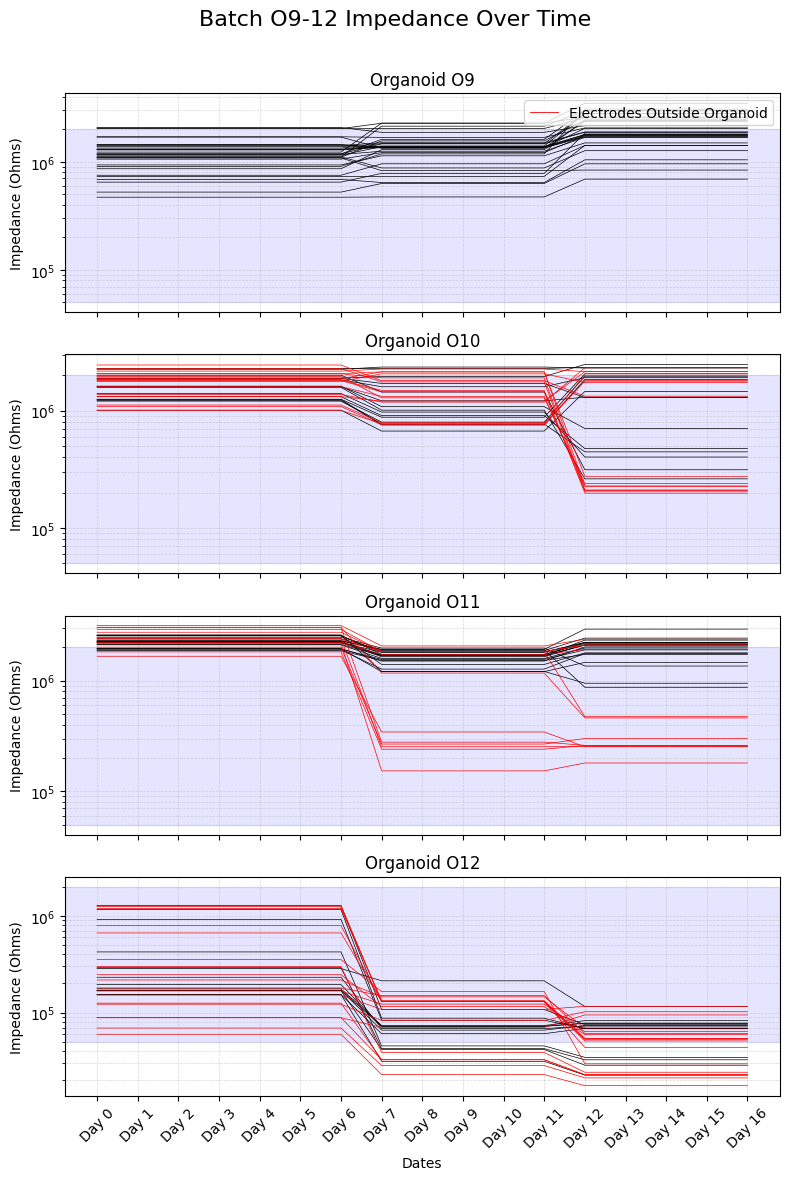

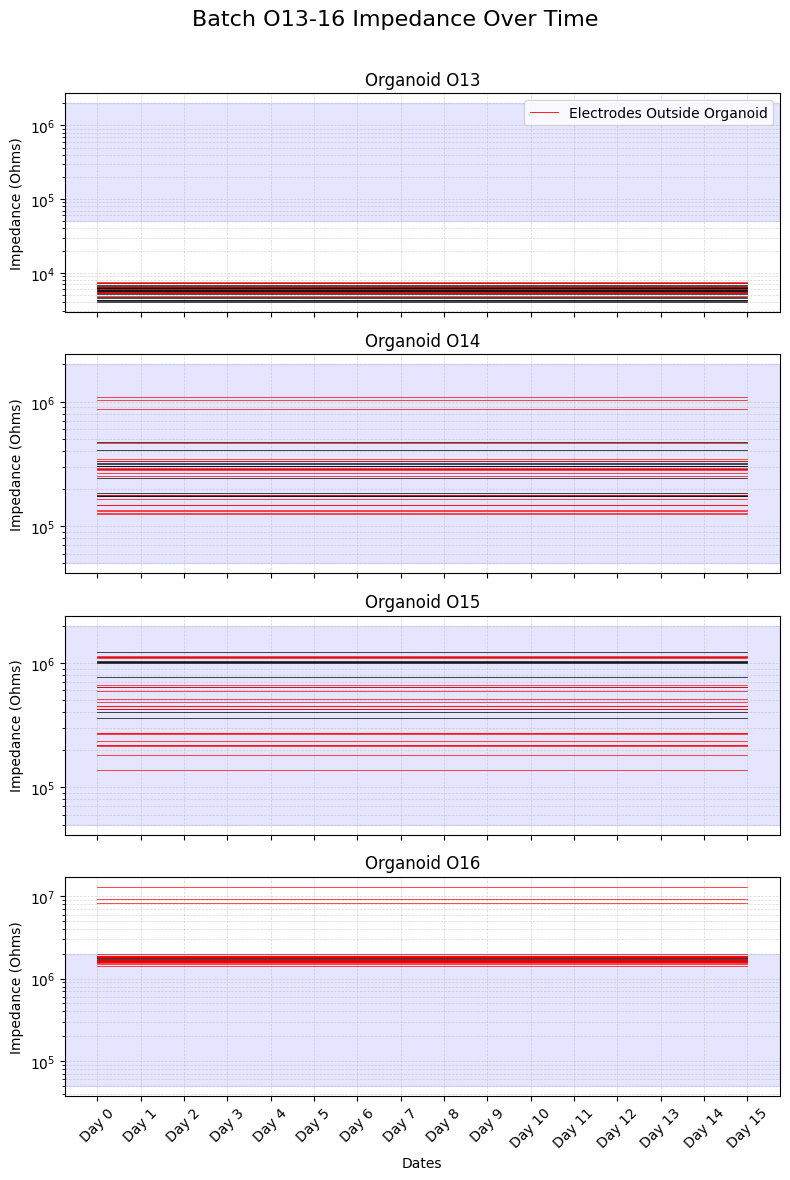

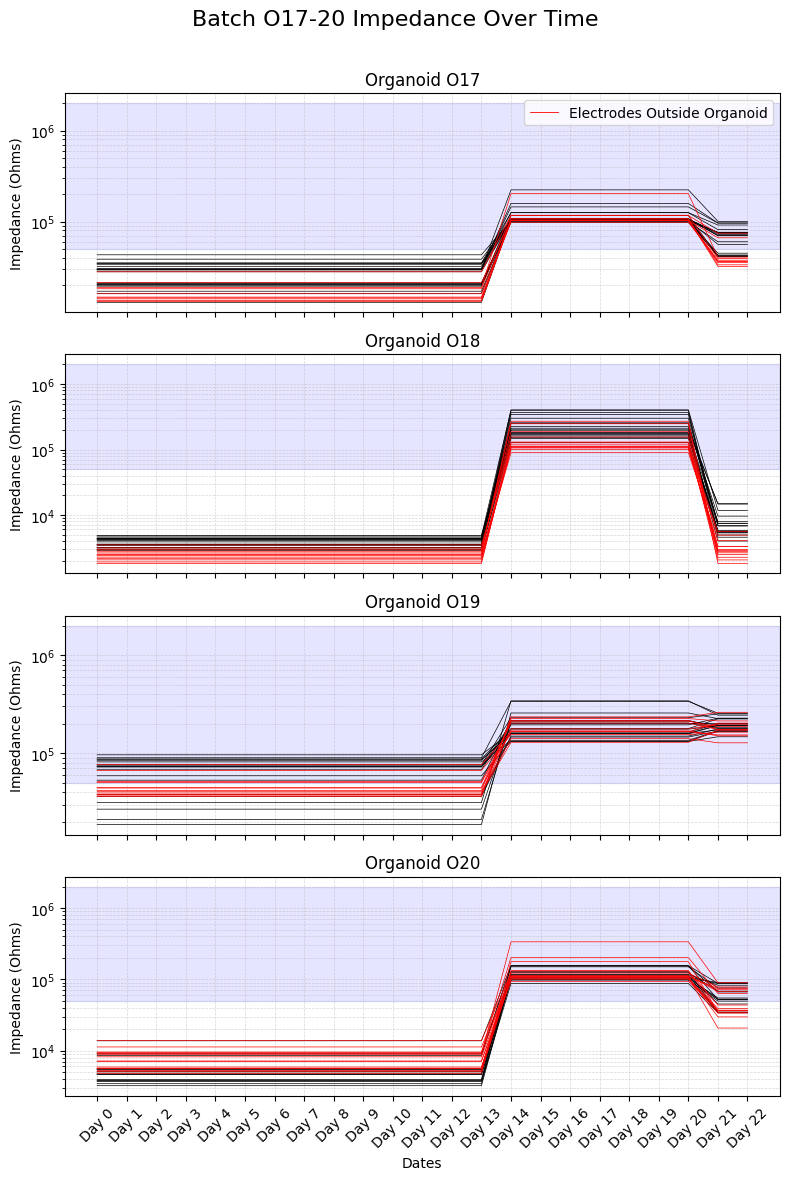

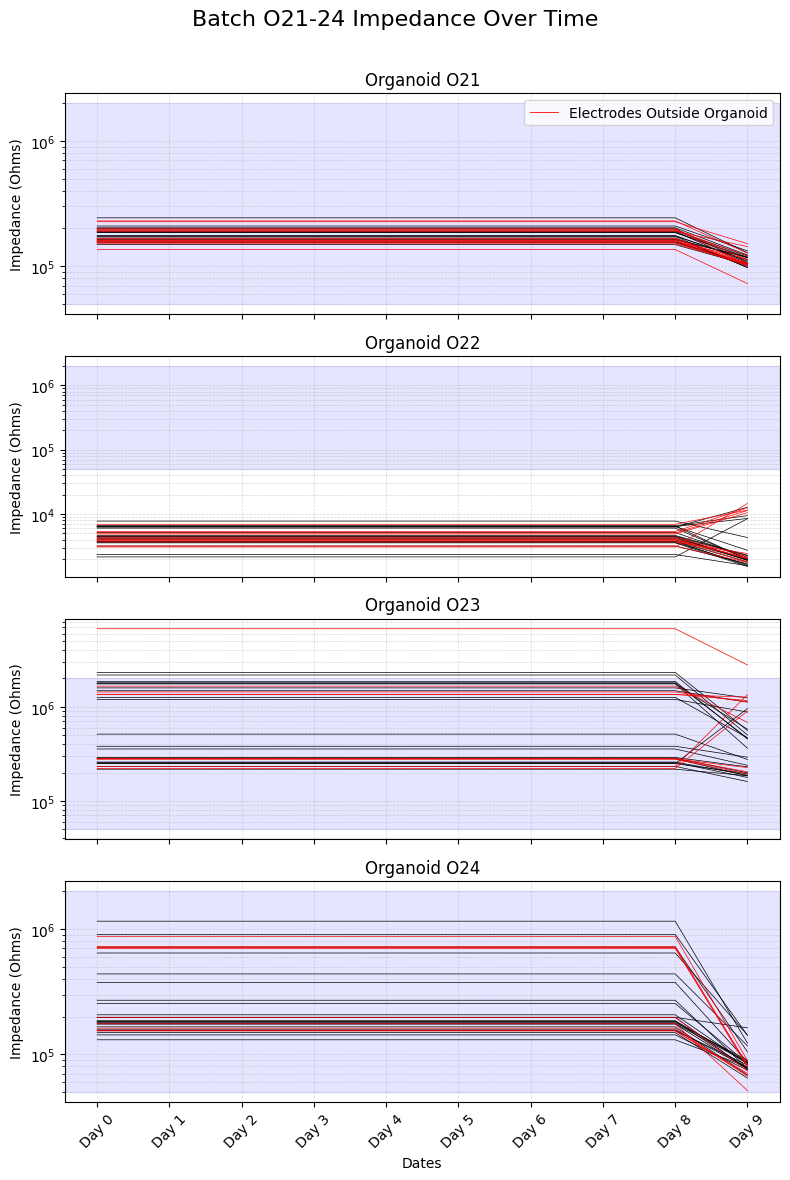

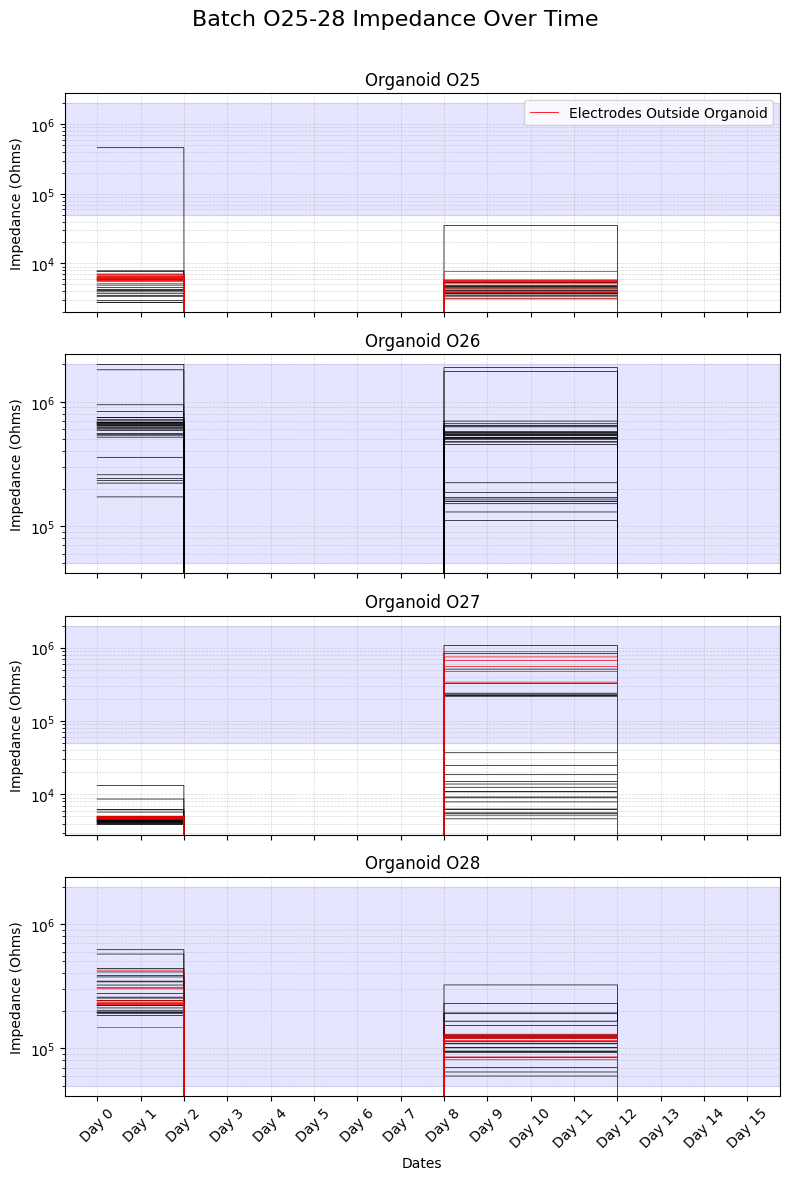

In [78]:
# Plot Impedance Values

xlabel = "Dates"
ylabel = "Impedance (Ohms)"

linecolor = "k"
linewidth = .5
yscale = "log"

I1 = 50000
I2 = 2000000
shadecolor = "b"
shade_alpha = 0.1  # Transparency for shaded region

for batch_id, batch_data in data["impedance"].items():
    organoids = get_organoid_ids(batch_id)  # List of 4 organoid IDs
    
    # Sort dates to ensure proper x-axis order
    num_days = batch_data.shape[2]
    
    fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)
    fig.suptitle(f"Batch {batch_id} Impedance Over Time", fontsize=16)
    
    elec_inside = get_num_elec_inside(batch_id=batch_id)

    for i in range(4):  # For each organoid
        ax = axs[i]
        for ch in range(32):

            if ch < elec_inside[i]: # if channel inside the organoid
                ax.plot(
                    range(num_days), 
                    batch_data[i, ch, :], 
                    color=linecolor, 
                    linewidth=linewidth
                )
            else:
                ax.plot(
                    range(num_days), 
                    batch_data[i, ch, :], 
                    color="r", 
                    linewidth=linewidth
                )                
        
        # Add shaded region
        ax.axhspan(I1, I2, color=shadecolor, alpha=shade_alpha)
        
        ax.set_yscale(yscale)
        ax.set_ylabel(ylabel)
        ax.set_title(f"Organoid {organoids[i]}")
        ax.grid(True, which='both', ls='--', lw=0.5, alpha=0.5)
    
    axs[-1].set_xticks(range(num_days))
    axs[-1].set_xticklabels([f"Day {i}" for i in range(num_days)], rotation=45)
    axs[-1].set_xlabel(xlabel)

    labelline = [mlines.Line2D([], [], color='red', linewidth=linewidth*1.2, label='Electrodes Outside of Organoid')]
    
    axs[0].legend(labelline, ["Electrodes Outside Organoid"], loc="upper right")
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for suptitle
    plt.show()

In [79]:
# Rule: An electrode needs to be inside the valid electrode range for at least 3 consecutive days. Those days will be considered.
from itertools import groupby

impedance_mask = {}
for batch_id, batch_data in data["impedance"].items():

    batch_filter = (batch_data >= I1) & (batch_data <= I2)

    for o in range(4):
        for ch in range(32):
            elec_filter = batch_filter[o,ch,:]

            # filter so needs 3 consecutive days
            new_elec_filter = []
            for k, g in groupby(elec_filter, lambda x: x == False):
                glist = list(g)
                if k:
                    new_elec_filter.extend(glist)
                else:
                    if len(glist) >= 3:
                        new_elec_filter.extend(glist)
                    else:
                        new_elec_filter.extend([not value for value in glist])   
            batch_filter[o,ch,:] = new_elec_filter

    # reorganize so instead of days its minutes (same day filter values)
    num_days = batch_data.shape[2]
    batch_filter = np.tile(batch_filter[:,:,:,np.newaxis], (1,1,1,1440)).reshape(4, 32, num_days*1440)

    # store in dictionary
    impedance_mask[batch_id] = batch_filter 


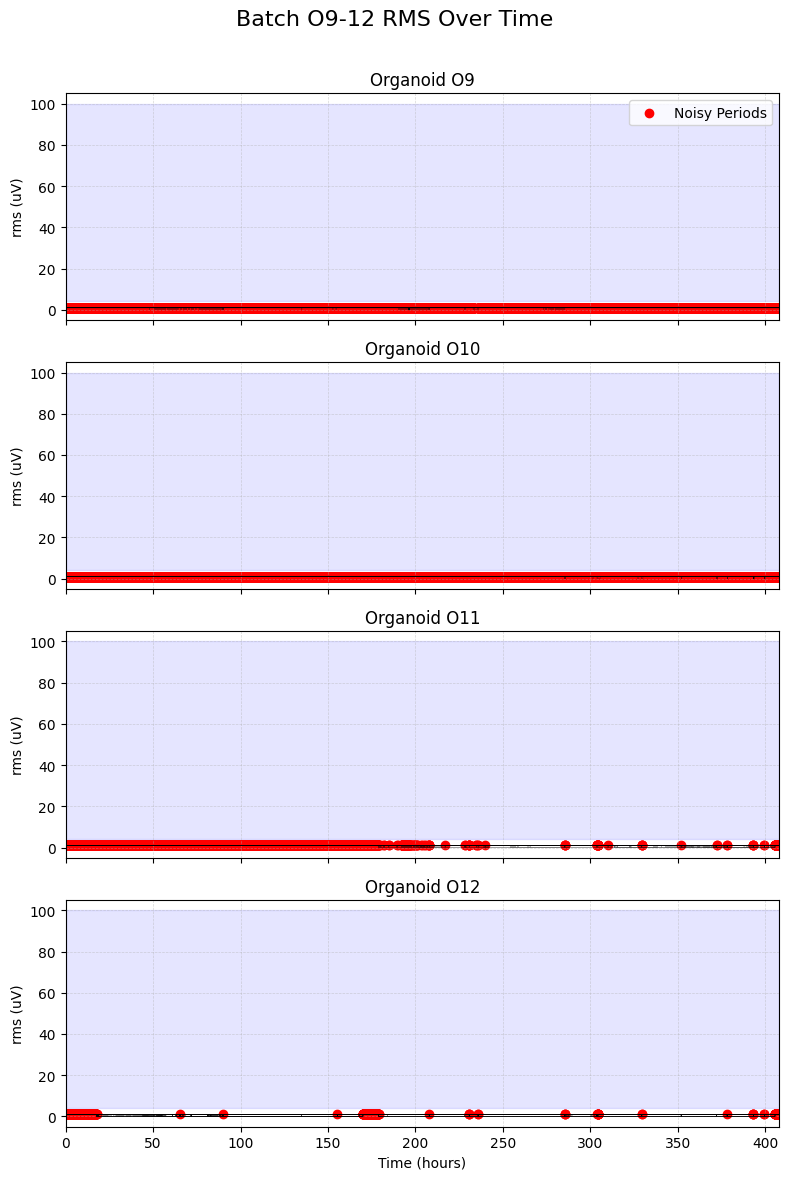

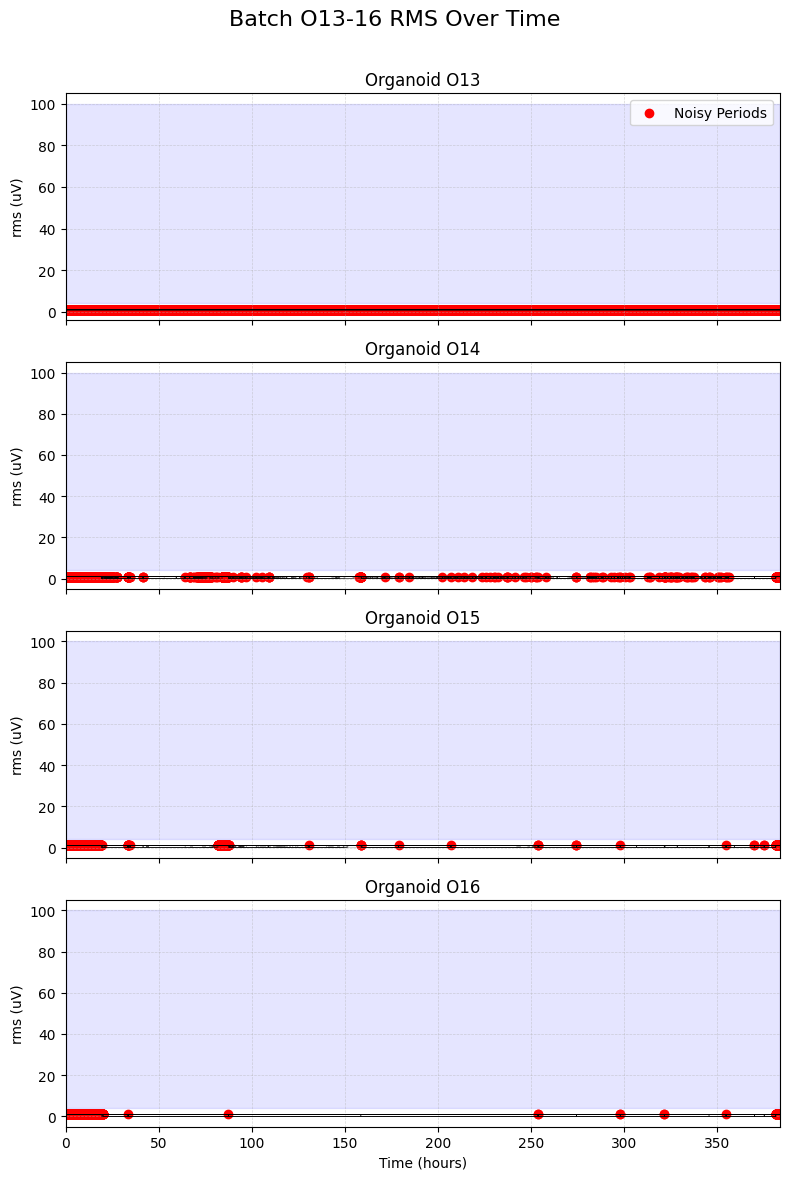

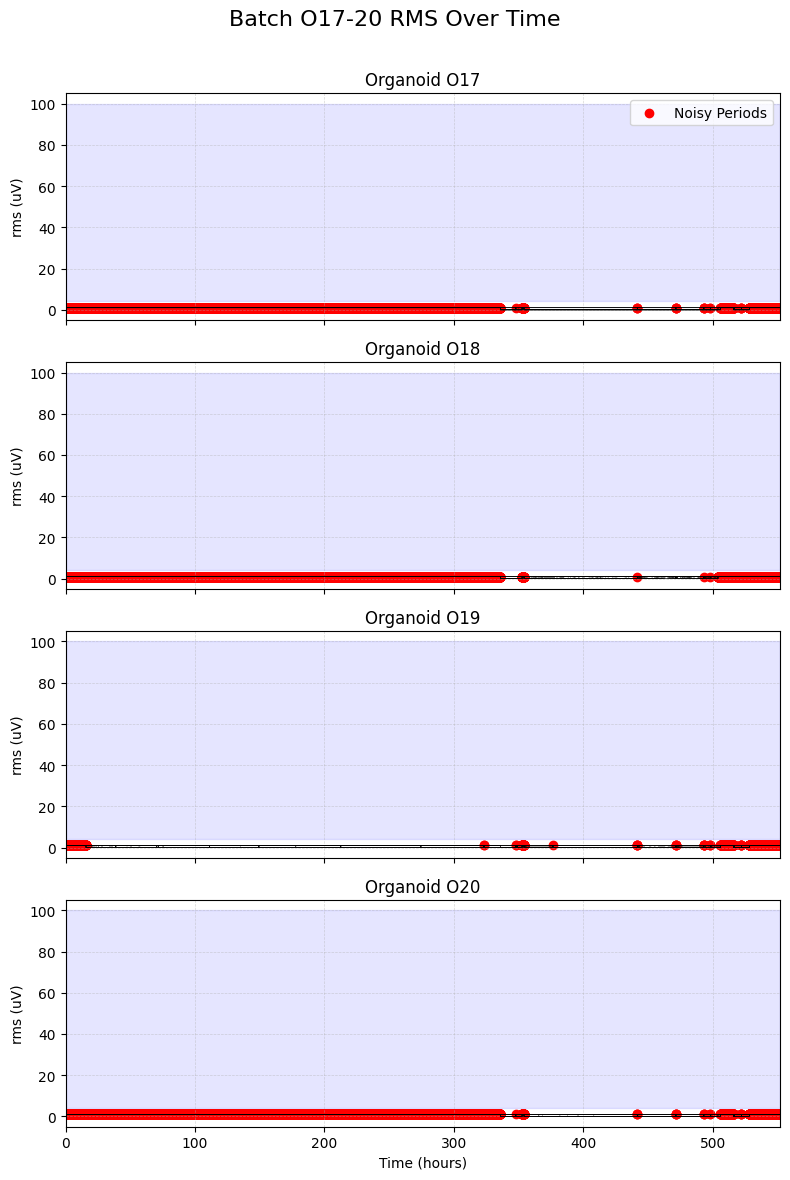

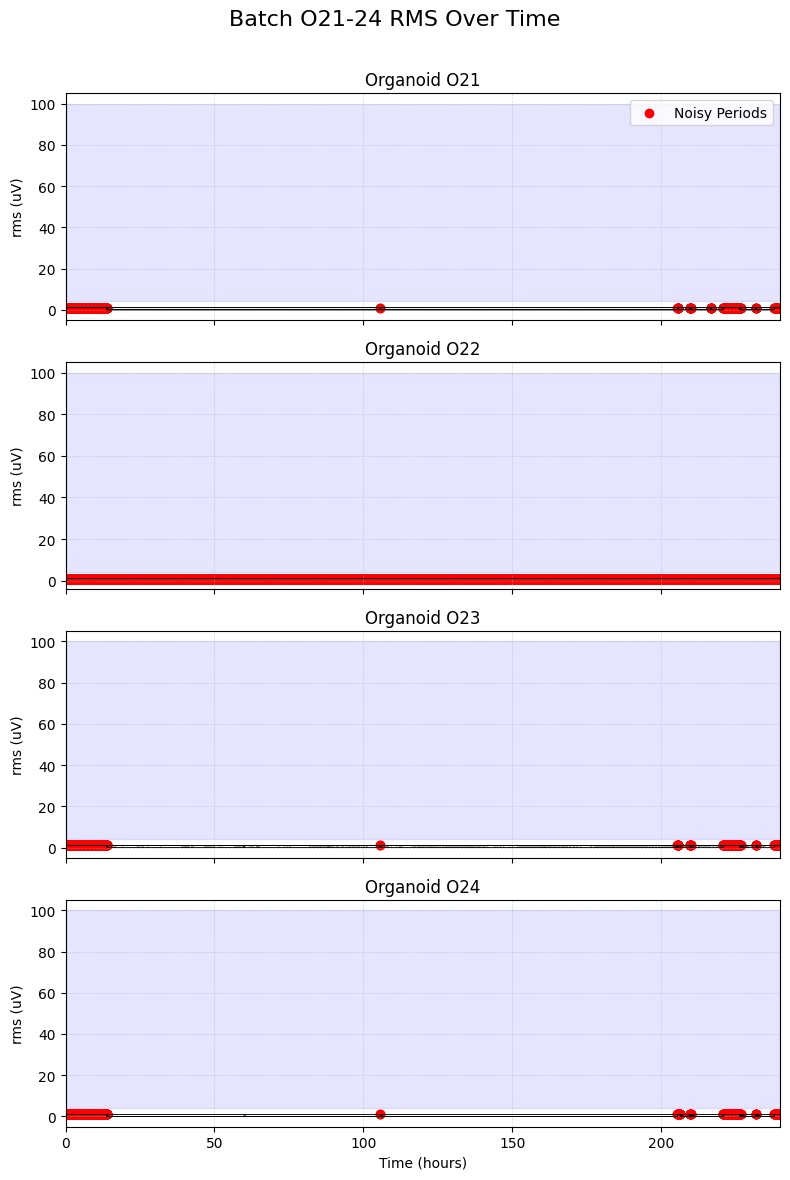

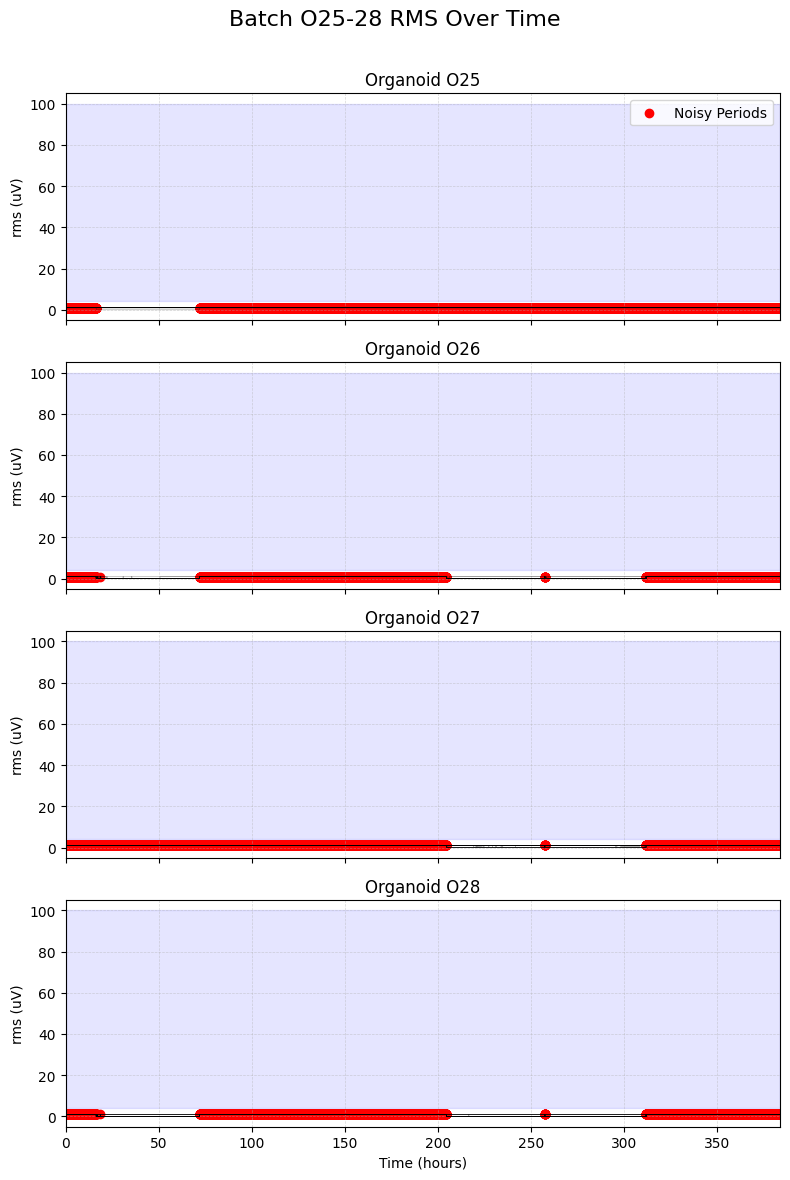

In [80]:
# Filter Based on RMS - Extract active time windows and electrodes (based on max rms values)
# Rule: Times which all channel rms values are within 5% of the mean will not be considered
#       Electrodes outside of the organoid or were impedance filtered will not be considered
xlabel = "Time (hours)"
ylabel = "rms (uV)"

linecolor = "k"
linewidth = .5

rms1 = 4
rms2 = 100
shadecolor = "b"
shade_alpha = 0.1  # Transparency for shaded region

noise_mask = {}
for batch_id, batch_data in data["rms"].items():

    # Filter out based on previous masks (inside elec, minutes, impedance)
    mask = np.all(np.stack(
        [minute_mask[batch_id],
          elec_inside_mask[batch_id],
            impedance_mask[batch_id]], axis=3), axis=3)
    
    filtered_data = batch_data.copy()
    filtered_data[~mask] = np.nan

    # Excuse any time points which all electrode rms is within 5% of the mean
    rms_mean = np.tile(np.nanmean(filtered_data, axis=1)[:,np.newaxis,:], (1,32,1))
    rms_error = rms_mean * .05

    # create masks to all() across channels
    # is true if theres 3 active channels (prevent false positives)
    a3_mask = np.sum(~np.isnan(filtered_data), axis=1) >= 3 # 4 x ~20000

    # is true if values fall within 5% of mean (nan values will be false)
    mean_mask = (filtered_data > rms_mean-rms_error) & (filtered_data < rms_mean+rms_error) # 4 x 32 x ~20000

    # make nan values true --> is true for orgs and times when all channels are either inactive or within mean range
    mean_mask = np.all( np.any(np.stack([mean_mask, np.isnan(filtered_data)], axis=3), axis=3) , axis=1) # 4 x ~20000

    # combine masks --> is true if there are at least 3 active channels and all channels are either inactive or within range
    artifact_mask = np.all(np.stack([a3_mask, mean_mask], axis=2), axis=2)
    noise_mask[batch_id] = np.tile(~artifact_mask[:,np.newaxis,:], (1,32,1)) # artifact = False

    # Plot Rms traces with artifacts marked
    fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)
    fig.suptitle(f"Batch {batch_id} RMS Over Time", fontsize=16)

    N = filtered_data.shape[2]
    x = np.arange(N)/60
    organoids = get_organoid_ids(batch_id)
    
    for i in range(4):  # For each organoid
        ax = axs[i]
        for ch in range(32):
            ax.plot(
                x, 
                filtered_data[i, ch, :], 
                color=linecolor, 
                linewidth=linewidth,
                alpha=.3
            )
        
        # Add shaded region
        ax.axhspan(rms1, rms2, color=shadecolor, alpha=shade_alpha)

        # add artifacts
        artifacts = artifact_mask[i, :]
        if i == 0:
            ax.scatter(x[artifacts], rms_mean[i, 0, artifacts], color="r", label="Noisy Periods")
            ax.legend(loc="upper right")
        else:
            ax.scatter(x[artifacts], rms_mean[i, 0, artifacts], color="r")
        
        ax.set_ylabel(ylabel)
        ax.set_title(f"Organoid {organoids[i]}")
        ax.grid(True, which='both', ls='--', lw=0.5, alpha=0.5)
        ax.set_xlim([0,x[-1]])
    
    axs[-1].set_xlabel(xlabel)
    
    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Leave space for suptitle
    plt.show()

c:\Users\Organoid PC\anaconda3\envs\utah_organoids\lib\site-packages\matplotlib\axes\_axes.py:7124: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.
  m, bins = np.histogram(x[i], bins, weights=w[i], **hist_kwargs)


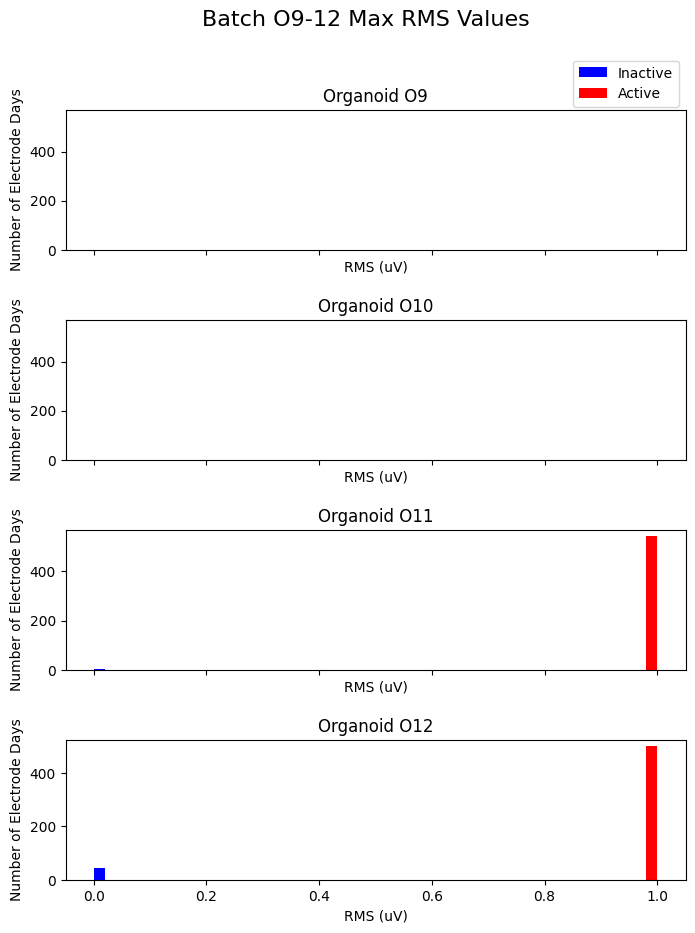

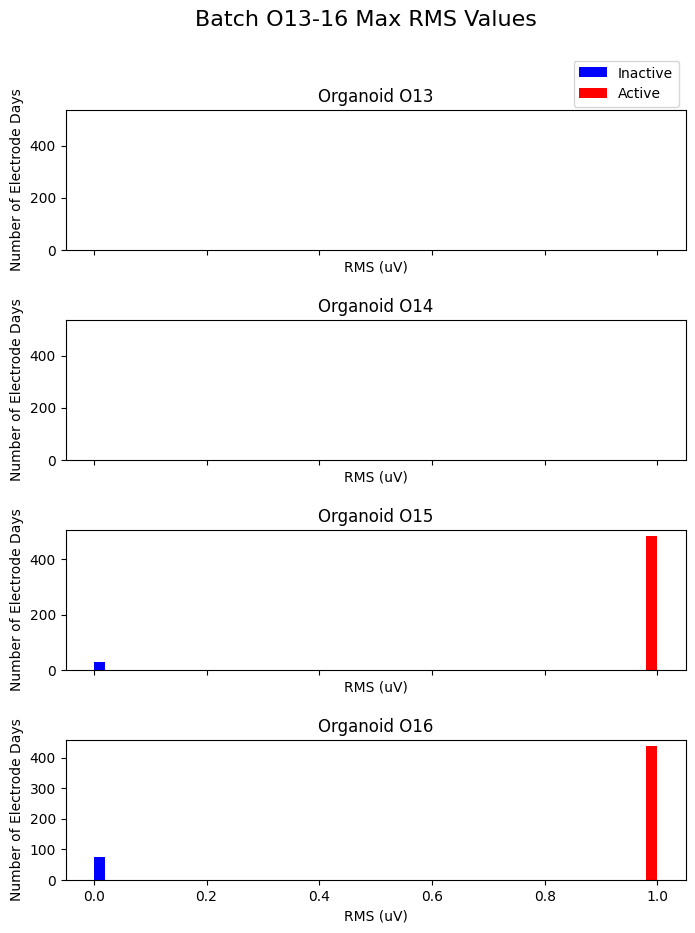

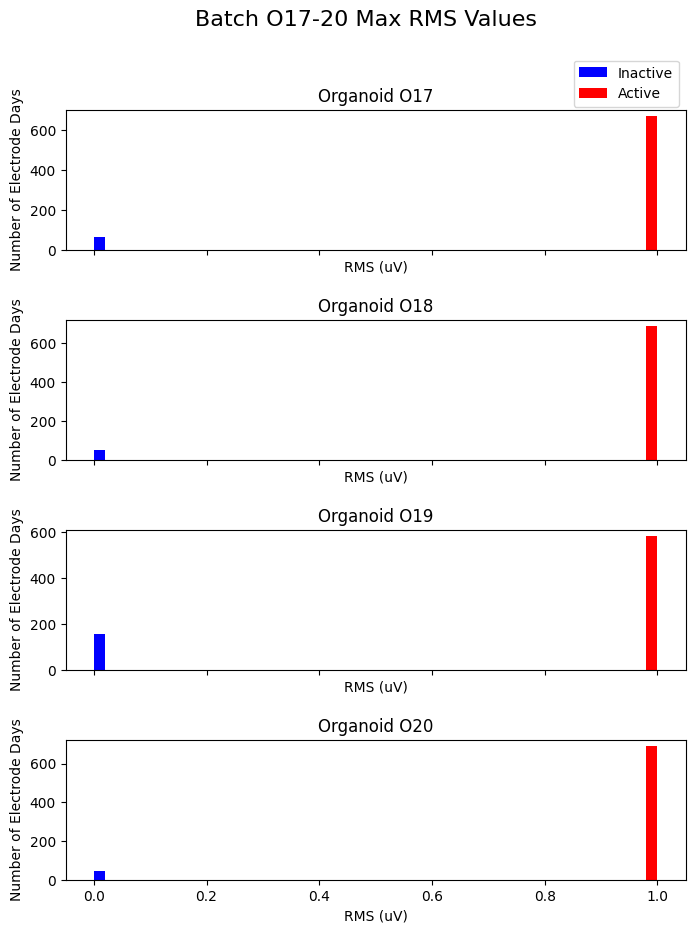

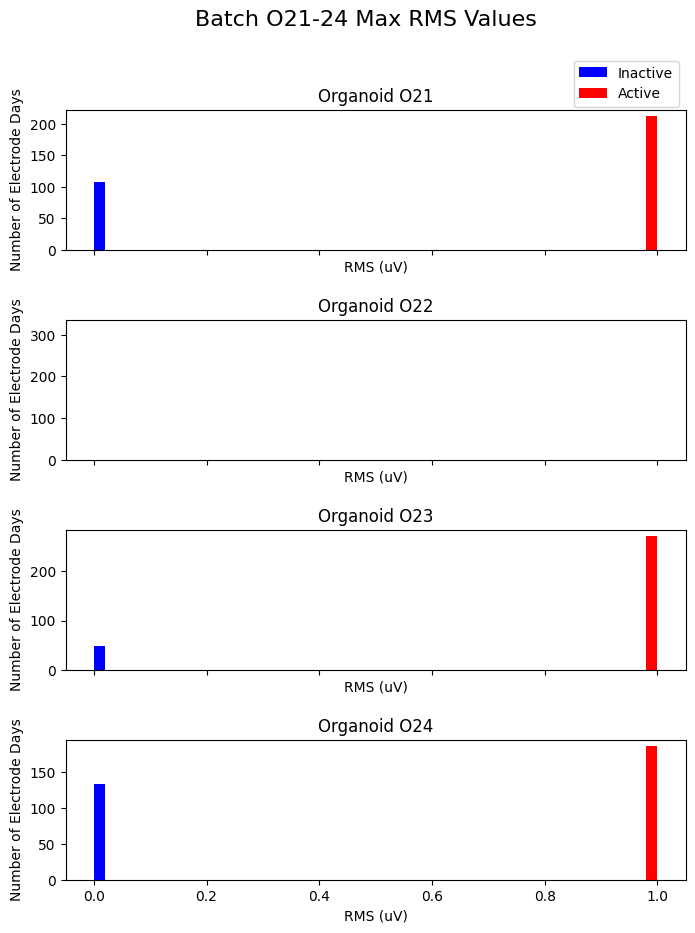

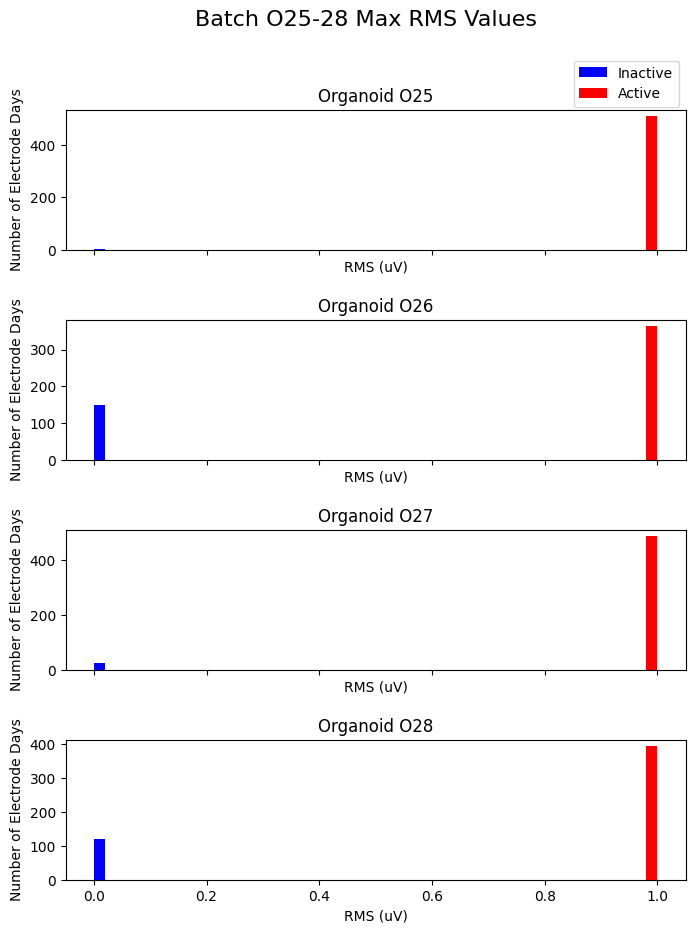

In [83]:
# Make Max RMS histograms to determine organoid dependent thresholds
# Rule: Recording Session (days) need to have a max rms value over a set threshold

dt = 24 * 60 # minutes
xlabel = "RMS (uV)"
ylabel = "Number of Electrode Days"

# thresholds = {
#    "O9-12": [25, 18, 10, 8],
#    "O13-16": [0, 17, 7, 5],
#    "O17-20": [20, 5, 30, 20],
#    "O21-24": [20, 20, 20, 20],
#    "O25-28": [10, 5, 3.5, 10]
# }
thresholds = {
   "O9-12": [2500, 1800, 1000, 800],
   "O13-16": [0, 17, 700, 500],
   "O17-20": [2000, 5, 3000, 2000],
   "O21-24": [2000, 2000, 2000, 2000],
   "O25-28": [1000, 500, 300.5, 1000]
}

rms_mask = {}
for batch_id, batch_data in data["rms"].items():
  
  rms_array = np.empty(batch_data.shape, dtype=bool)

  # Filter out based on previous masks (inside elec, minutes, impedance, artifact regions)
  batch_mask = np.all(np.stack(
      [minute_mask[batch_id],
        elec_inside_mask[batch_id],
          impedance_mask[batch_id],
          # noise_mask[batch_id]
          ], axis=3), axis=3)
  
  filtered_data = batch_data.copy()
  filtered_data[~batch_mask] = np.nan

  N = int(filtered_data.shape[2] / dt)
  organoids = get_organoid_ids(batch_id)

  fig, axs = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
  fig.subplots_adjust(hspace=.5)
  fig.suptitle(f"Batch {batch_id} Max RMS Values", fontsize=16)
  for o in range(4):

    ax = axs[o]
    thresh = .5
    org_rms_values = []  
    for i in range(N):

      w = np.arange(dt*i, dt*(i+1)) # recording segment vector
      session_data = filtered_data[o,:,w].transpose()

      # find max value during window
      max_rms = np.nanmax(session_data, axis=1)

      # add info to rms mask
      if isinstance(thresh, tuple):
        rms_array[o,:,w] = (thresh[0] <= max_rms) & (max_rms <= thresh[1])
      elif isinstance(thresh, int):
        rms_array[o,:,w] = (thresh <= max_rms)

      max_rms = max_rms[~np.isnan(max_rms)] # remove nan values
      org_rms_values.extend(max_rms)
    org_rms_values = np.array(org_rms_values)

    if len(org_rms_values) > 0:
      x = np.linspace(org_rms_values.min(), org_rms_values.max(), 50)
      
      # Find values for active electrode / days
      if isinstance(thresh, tuple):
        thresh_logical =  (thresh[0] <= org_rms_values) & (org_rms_values <= thresh[1])
      elif isinstance(thresh, (int, float)):
        thresh_logical = (org_rms_values > thresh)
      ax.hist(org_rms_values[~thresh_logical], x, color="b", label="Inactive")
      ax.hist(org_rms_values[thresh_logical], x, color="r", label="Active")
    ax.set_title(f"Organoid {organoids[o]}")
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if o == 0:
      ax.legend(bbox_to_anchor=(1, 1.40), loc="upper right")

    rms_mask[batch_id] = rms_array

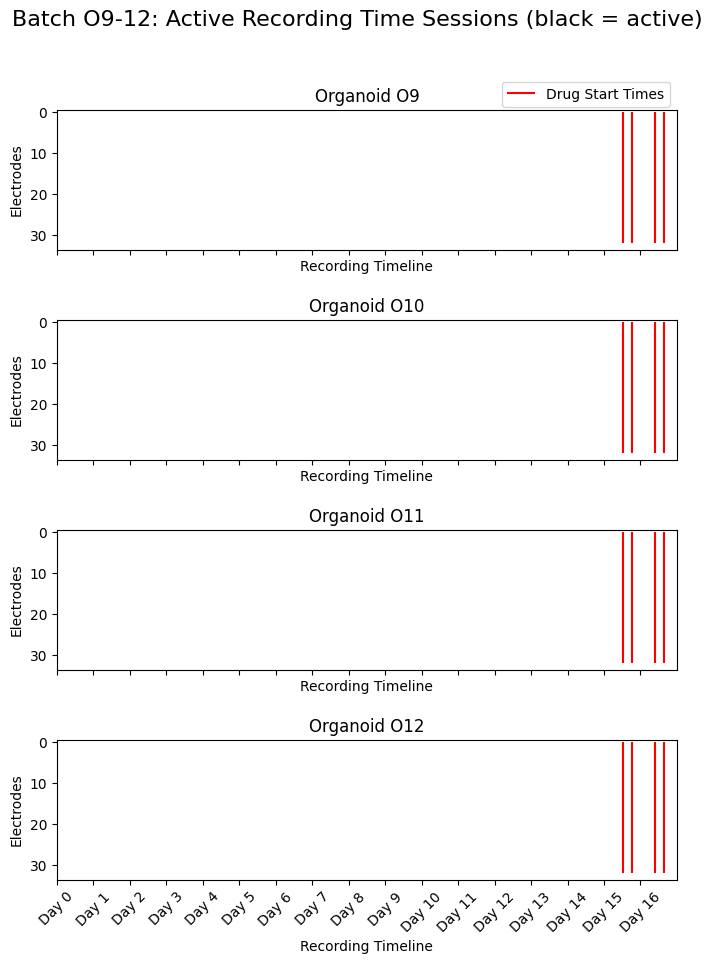

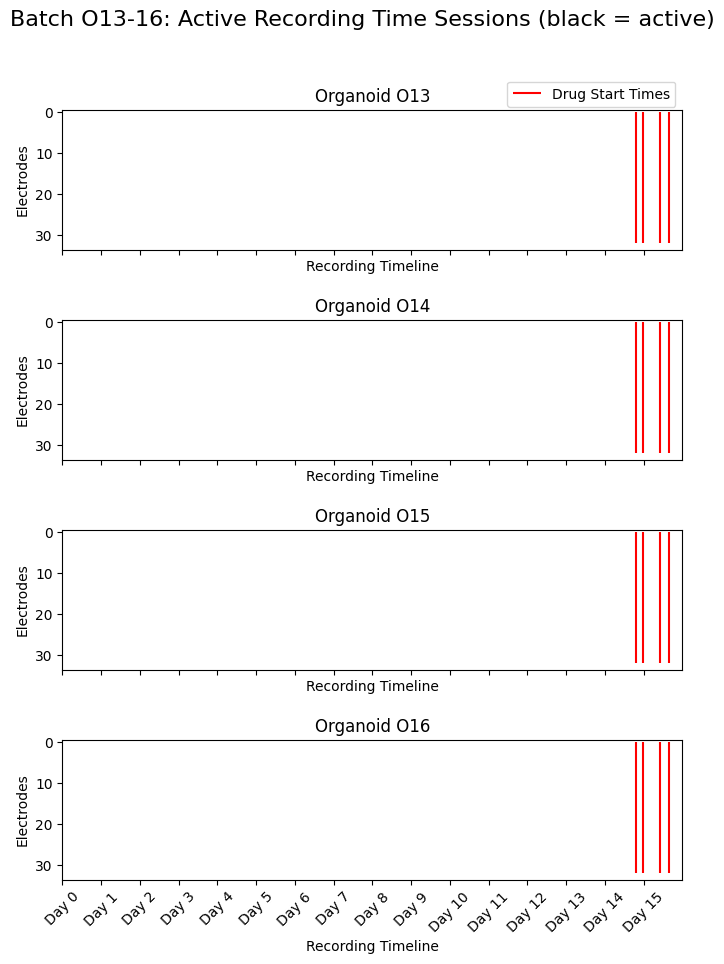

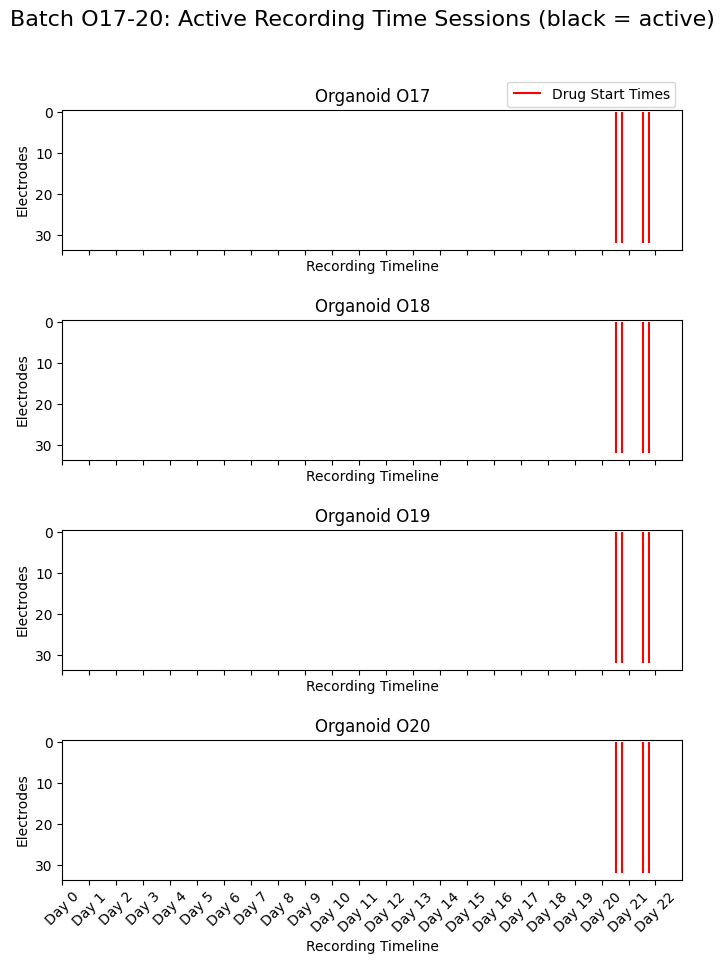

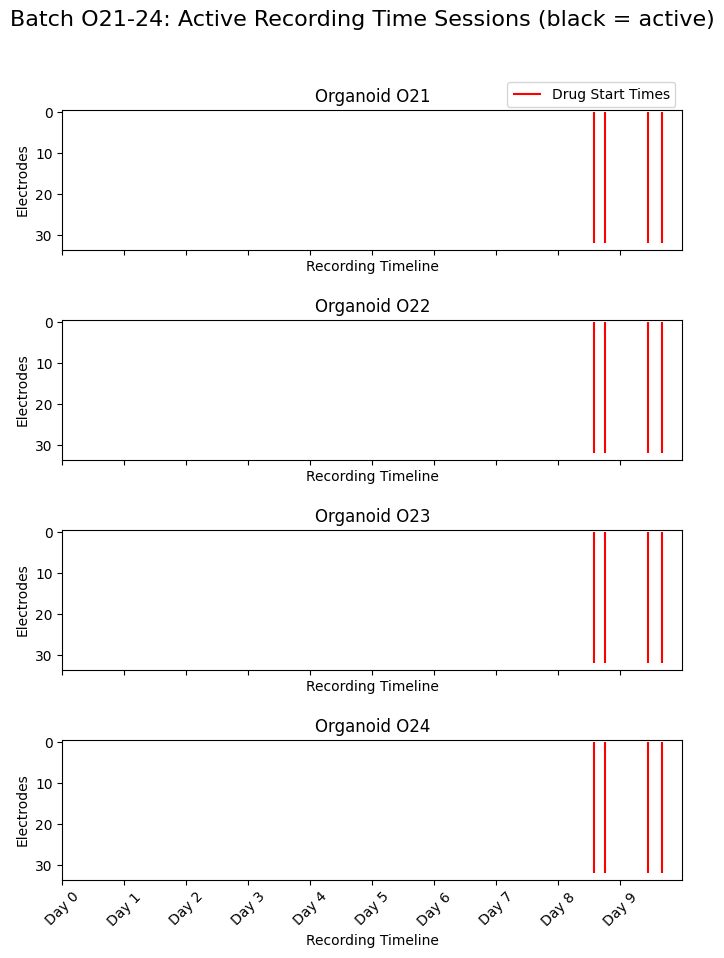

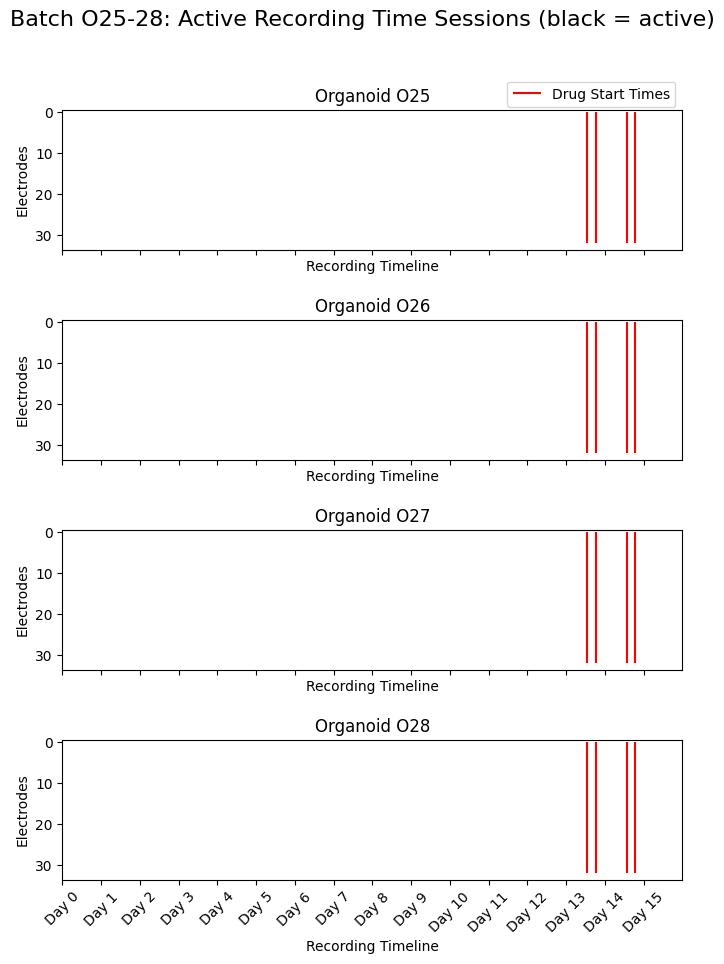

In [84]:
# Plot the accepted time periods for the batch recordig session
xlabel = "Recording Timeline"
ylabel = "Electrodes"
title = "Active Recording Time Sessions (black = active)"
for batch_id in batch_ids:

  # Filter out based on previous masks (inside elec, minutes, impedance, artifact regions, active rms)
  batch_mask = np.all(np.stack(
      [minute_mask[batch_id],
        elec_inside_mask[batch_id],
          impedance_mask[batch_id],
          # noise_mask[batch_id],
          rms_mask[batch_id]], axis=3), axis=3)
  
  N = int(batch_mask.shape[2] / 1440)

  xticks = np.arange(N)*1440
  xticklabels = [f"Day {int(x/1440)}" for x in xticks]

  organoids = get_organoid_ids(batch_id)

  start_time = get_drug_times(batch_id, "Control")[0].replace(hour=0, minute=0)
  drugs = ["4-AP", "No Drug", "Bicuculline", "Tetrodotoxin"]
  didx = [int((get_drug_times(batch_id, drug)[0] - start_time).total_seconds() / 60) for drug in drugs] # minutes

  fig, axs = plt.subplots(4, 1, figsize=(8, 10), sharex=True)
  fig.subplots_adjust(hspace=.5)
  fig.suptitle(f"Batch {batch_id}: {title}", fontsize=16)
  
  for o in range(4):
    ax = axs[o]

    ax.imshow(batch_mask[o,:,:], aspect="auto", cmap="binary")
    ax.vlines(x=didx, ymin=[0]*len(didx), ymax=[32]*len(didx),colors="red", label="Drug Start Times")
    if o == 0:
      ax.legend(bbox_to_anchor=(1, 1.25), loc="upper right")

    ax.set_title(f"Organoid {organoids[o]}")
    ax.set_xlabel(xlabel)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels, rotation=45)
    ax.set_ylabel(ylabel)

    